In [1]:
import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import matplotlib.cm as cm
import numpy as np
import matplotlib
# Prevent ptitprince from raising cmap errors
cm.register_cmap = lambda name, cmap : matplotlib.colormaps.register(cmap, name=name)
import ptitprince as pt

import jax.numpy as jnp
import pypomp as pp
import ipywidgets as widgets
import pandas as pd
import copy

from jax import jit, grad
from functools import partial

from tqdm import tqdm


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
np.set_printoptions(suppress=True)

In [ ]:
from pypomp.train import _jgrad_mop
d = pp.dacca(gamma=False)
theta = d.theta
theta_orig = np.hstack(list(d.par_trans.to_est(theta[0]).values()))
grads = {'0.0' : [], '1.0' : [], '0.97' : []}
alphas = [0.,1.,0.97]
for i in tqdm(range(100)):
  for alpha in alphas:
    d.train(J=10000, M=1, 
                          theta=theta,
                        optimizer='SGD', eta=1, 
                          ls=False, scale=False, 
                          alpha=alpha, key=jax.random.PRNGKey(i))
    theta_new = np.hstack(list(d.par_trans.to_est(d.theta[0]).values()))
    grads[str(alpha)].append(theta_new - theta_orig)

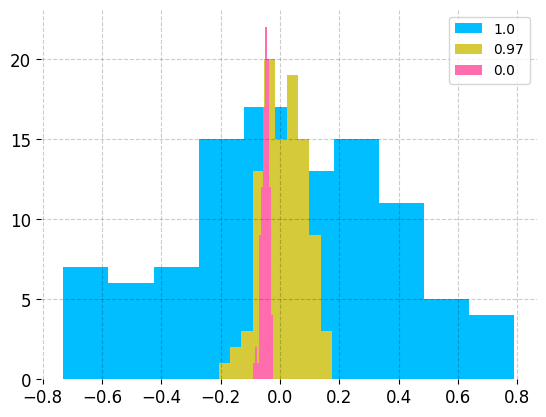

In [88]:
for alpha in [1.0, 0.97, 0.0]:
    plt.hist(np.array(grads[str(alpha)])[:,0], alpha=1, label=alpha)
plt.legend()

In [2]:
params_box = {'gamma': [10.,  40.],
                 'epsilon': [0.20, 30.00],
                 'rho': [0.0, 0.0],
                 'm': [0.03, 0.60],
                 'c': [1.0, 1.0],
                 'beta_trend': [-1.*0.01, -0.*0.01],
                 'bs1': [-4., 4.],
                 'bs2': [0., 8.],
                 'bs3': [-4., 4.],
                 'bs4': [0., 8.],
                 'bs5': [0., 8.],
                 'bs6': [0., 8.],
                 'sigma': [1., 5.],
                 'tau': [0.1, 0.5],
                 'omega': [np.exp(-4.5), np.exp(-4.5)],
                 'omegas1': [-10., -0.],
                 'omegas2': [-10., -0.],
                 'omegas3': [-10., -0.],
                 'omegas4': [-10., -0.],
                 'omegas5': [-10., -0.],
                 'omegas6': [-10., -0.]}

In [3]:
MAIN_SEED = 631409
key = jax.random.key(MAIN_SEED)
np.random.seed(MAIN_SEED)

RW_SD = pp.RWSigma(
    sigmas={
        "gamma": 0.02,
        "m": 0.02,
        "rho": 0.0,
        "epsilon": 0.02,
        "omega": 0.02,
        "c": 0.02,
        "beta_trend": 0.02,
        "sigma": 0.02,
        "tau": 0.02,
        "bs1": 0.02,
        "bs2": 0.02,
        "bs3": 0.02,
        "bs4": 0.02,
        "bs5": 0.02,
        "bs6": 0.02,
        "omegas1": 0.02,
        "omegas2": 0.02,
        "omegas3": 0.02,
        "omegas4": 0.02,
        "omegas5": 0.02,
        "omegas6": 0.02,
    },
    init_names=[],
)

COOLING_RATE = 0.5
NP_FITR = NP_EVAL = 10000

N_TRIALS = 100
NREPS_EVAL = 1
NFITR_MIF = 40
NFITR_GD = 60


# NREPS_EVAL = 1
# NFITR_MIF = 2 #40
# NFITR_GD = 2
#N_TRIALS = 2
alphas = [0.,1.,0.97]
daccas_pre = []
daccas_mif = []
daccas_alphas = {str(alpha) : [] for alpha in alphas}

starting_logliks = []
mif_logliks = []


dacca_obj = pp.dacca(gamma=False)
for trial in tqdm(range(N_TRIALS)):
    dacca_obj.results_history = []
    key, subkey = jax.random.split(key)
    theta = pp.Pomp.sample_params(params_box, 1, key=subkey)[0]
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL, key=subkey, theta=theta)
    print('trial ' + str(trial) + ' init :', dacca_obj.results())
    
    key, subkey = jax.random.split(key)
    dacca_obj.mif(
            theta=theta,
            rw_sd=RW_SD,
            M=NFITR_MIF,
            a=COOLING_RATE,
            J=NP_FITR,
            key=subkey
        )
    
    #warm_start_theta = dacca_obj.theta
    trace = dacca_obj.results_history[-1]['traces']
    argmax = int(trace[0,:,0].argmax())

    warm_start_theta = pd.DataFrame(trace[0,argmax,1:].values, index=theta.keys())[0]
    warm_start_theta = [{k : float(v) for k, v in warm_start_theta.items()}]
    
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
    print('trial ' + str(trial) + ' mif 40:', dacca_obj.results())
    daccas_pre.append(dacca_obj.results())

    key, subkey = jax.random.split(key)
    dacca_obj.mif(
                theta=theta,
                rw_sd=RW_SD,
                M=NFITR_MIF+NFITR_GD,
                a=COOLING_RATE,
                J=NP_FITR,
                key=subkey
            )
    
    key, subkey = jax.random.split(key)
    dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
    print('trial ' + str(trial) + ' mif 100:', dacca_obj.results())
    daccas_mif.append(dacca_obj.results())

    for alpha, eta in tqdm(zip(alphas, [0.1, 0.05, 0.2])):
        key, subkey = jax.random.split(key)
        dacca_obj.train(J=NP_FITR, M=NFITR_GD, 
                          theta=warm_start_theta,
                        optimizer='SGD', eta=eta, 
                          ls=False, scale=False, 
                          alpha=alpha, key=subkey)
        key, subkey = jax.random.split(key)
        dacca_obj.pfilter(J=NP_EVAL, reps=NREPS_EVAL)
        print('trial ' + str(trial) + ' alpha=', str(alpha),':', dacca_obj.results())
        daccas_alphas[str(alpha)].append(dacca_obj.results())


pd.concat({k : pd.concat(daccas_alphas[str(k)]).reset_index(drop=True) for k in alphas}, axis=0).to_csv('runs.csv')
pd.concat(daccas_mif).reset_index(drop=True).to_csv('mif.csv')
pd.concat(daccas_pre).reset_index(drop=True).to_csv('pre.csv')

  0%|          | 0/100 [00:00<?, ?it/s]

trial 0 init :         logLik  se      gamma    epsilon  rho         m    c  beta_trend  \
0 -14715.84375 NaN  34.645187  10.470056  0.0  0.533827  1.0   -0.002874   

        bs1       bs2  ...      bs6     sigma       tau     omega   omegas1  \
0 -0.793052  5.290325  ...  2.56705  3.964456  0.112241  0.011109 -2.392839   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.877694 -1.420382 -3.457628 -0.317747 -3.187977  

[1 rows x 23 columns]
trial 0 mif 40:         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3933.774658 NaN  38.017269  0.083694  0.0  9.756901  0.084818  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003223  3.647373  ...  1.413181  3.85019  4.039347  4.329221 -0.530728   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.056757 -1.352057 -6.087426 -6.186818 -8.085534  

[1 rows x 23 columns]
trial 0 mif 100:         logLik  se     gamma         m  rho   epsilon     omega    c


0it [00:00, ?it/s]
2it [03:02, 89.33s/it] 

trial 0 alpha= 1.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3780.160156 NaN  27.095818  0.09008  0.0  9.284538  0.143111  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002085  3.539579  ...  0.448001  3.689385  3.799845  4.304871   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.927416 -6.40453 -1.854383 -5.609494 -5.366438 -7.338479  

[1 rows x 23 columns]



3it [04:23, 87.80s/it]
  1%|          | 1/100 [05:41<9:22:47, 341.09s/it]

trial 0 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3771.697021 NaN  26.107149  0.087769  0.0  11.909852  0.143111  1.0   

   beta_trend     sigma  ...       bs3      bs4      bs5       bs6   omegas1  \
0   -0.003315  3.358548  ...  0.344965  3.66188  3.83018  4.247191 -1.880638   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -6.383383 -1.975215 -5.747964 -5.435399 -7.34438  

[1 rows x 23 columns]
trial 1 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5315.491699 NaN  22.867544  0.280638  0.0  27.449808  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008323  2.946764  ...  3.076502  0.229012  5.189916  1.380099   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -8.159295 -1.197272 -9.484786 -8.835987 -2.270836 -3.64519  

[1 rows x 23 columns]
trial 1 mif 40:         logLik  se     gamma         m  rho    epsilon     omega 


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 1 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3842.762207 NaN  13.988167  0.081387  0.0  26.175676  0.000763  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.006798  2.713229  ... -1.425506  3.29531  3.303537  4.150525 -4.392503   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0  3.628756 -9.332391 -3.451694 -8.000321 -2.597822  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 1 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3834.499512 NaN  12.435254  0.074877  0.0  26.953764  0.000763  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0      -0.007  3.21283  ... -1.420583  3.271951  3.278781  4.121725 -4.45884   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0  3.564994 -9.356469 -3.489214 -8.009982 -2.609483  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
  2%|▏         | 2/100 [10:04<8:02:27, 295.38s/it]

trial 1 alpha= 0.97 :         logLik  se      gamma       m  rho    epsilon     omega    c  \
0 -3833.492188 NaN  12.572148  0.0735  0.0  25.450991  0.000763  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006516  3.100782  ... -1.426277  3.297171  3.345772  4.107154   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.421957  3.659221 -9.298484 -3.438529 -8.041576 -2.634862  

[1 rows x 23 columns]
trial 2 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -5129.739746 NaN  17.373196  0.099508  0.0  24.96874  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003512  2.582504  ...  1.054761  3.081449  1.561035  6.462576   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.311194 -5.770906 -2.122004 -8.232218 -0.168401 -7.556738  

[1 rows x 23 columns]
trial 2 mif 40:         logLik  se      gamma         m  rho    epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 2 alpha= 0.0 :       logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3823.8125 NaN  22.72644  0.065374  0.0  8.757195  0.011122  1.0   

   beta_trend   sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.002602  3.7935  ... -0.660958  3.790274  3.527941  4.117759 -7.851609   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.860827 -2.282998 -5.794884 -5.118775 -8.050935  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 2 alpha= 1.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3789.732178 NaN  25.107861  0.076454  0.0  8.38864  0.011122  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005977  3.496381  ... -0.499865  3.911858  3.545268  4.265988   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.853478 -4.853514 -2.223512 -5.753016 -5.153435 -8.070317  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
  3%|▎         | 3/100 [14:27<7:33:52, 280.74s/it]

trial 2 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3780.584473 NaN  23.680605  0.082539  0.0  9.866035  0.011122  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0    -0.00367  3.118129  ... -0.547675  3.797675  3.653157  4.296798 -7.84769   

   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -4.85147 -2.265071 -5.818813 -5.214816  -8.0787  

[1 rows x 23 columns]
trial 3 init :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -5761.811035 NaN  29.844267  0.087622  0.0  3.74114  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005178  4.944207  ...  1.968425  2.307203  5.463696  4.067067   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.761091 -3.409951 -0.605268 -3.05132 -3.887935 -4.872867  

[1 rows x 23 columns]
trial 3 mif 40:         logLik  se      gamma         m  rho    epsilon     omega    c 


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 3 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3754.755615 NaN  22.647543  0.054286  0.0  21.17243  0.048131  1.0   

   beta_trend     sigma  ...       bs3       bs4     bs5       bs6   omegas1  \
0   -0.003642  3.221857  ... -1.301335  3.729007  3.6064  4.292892 -2.559507   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -1.419752 -3.27497 -4.341585 -6.952789 -5.246439  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 3 alpha= 1.0 :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -3751.114258 NaN  22.469841  0.05782  0.0  22.011534  0.048131  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004321  3.363094  ... -1.287059  3.724967  3.591157  4.300384   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -2.573225 -1.393849 -3.262618 -4.330932 -6.96107 -5.274249  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
  4%|▍         | 4/100 [18:51<7:18:13, 273.89s/it]

trial 3 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3753.834961 NaN  23.950167  0.059173  0.0  22.17153  0.048131  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00458  3.316226  ... -1.288006  3.772886  3.629334  4.304813   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -2.546064 -1.421195 -3.284429 -4.356991 -6.989225 -5.26377  

[1 rows x 23 columns]
trial 4 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5402.739746 NaN  17.957466  0.362799  0.0  26.116594  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009084  2.071959  ...  1.979115  4.299366  1.811437  3.774222   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.580704 -1.002574 -9.360171 -9.862537 -3.941894 -5.851972  

[1 rows x 23 columns]
trial 4 mif 40:         logLik  se      gamma         m  rho    epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 4 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3854.616699 NaN  14.773643  0.046595  0.0  17.96793  0.013166  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0    -0.00434  2.684908  ...  0.807021  3.092633  3.424095  4.203493 -3.82214   

    omegas2    omegas3   omegas4  omegas5  omegas6  
0  5.012528 -11.350697 -4.802905  -4.7207 -7.88685  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 4 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3847.834473 NaN  12.510487  0.040051  0.0  18.09458  0.013166  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.003476  3.376865  ...  0.836028  3.100522  3.40429  4.085816 -3.884522   

    omegas2    omegas3   omegas4   omegas5   omegas6  
0  4.933208 -11.361007 -4.801289 -4.720996 -7.898255  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
  5%|▌         | 5/100 [23:14<7:07:37, 270.07s/it]

trial 4 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3844.079102 NaN  13.199412  0.045127  0.0  18.205568  0.013166  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.004323  3.213832  ...  0.804081  3.11251  3.415614  4.113808 -3.927597   

    omegas2    omegas3   omegas4   omegas5   omegas6  
0  4.915468 -11.331313 -4.781764 -4.746012 -7.901788  

[1 rows x 23 columns]
trial 5 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6098.172852 NaN  19.540045  0.110105  0.0  25.898726  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009034  3.549231  ...  2.776061  5.046771  4.036434  5.286874   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.950332 -1.900623 -9.473301 -1.71894 -6.546921 -3.764071  

[1 rows x 23 columns]
trial 5 mif 40:         logLik  se      gamma         m  rho   epsilon     


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 5 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3764.529785 NaN  23.685118  0.063326  0.0  11.74251  0.006013  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004549  3.385932  ... -0.451556  3.833571  3.570102  4.410784   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.924351 -1.696861 -3.341772 -4.036706 -7.580538 -4.735239  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 5 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3769.144531 NaN  23.417267  0.061747  0.0  10.692439  0.006013  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00709  3.501695  ... -0.379169  3.790458  3.575747  4.482069   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.932231 -1.667985 -3.278583 -3.992381 -7.584651 -4.746593  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
  6%|▌         | 6/100 [27:37<6:59:32, 267.79s/it]

trial 5 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3754.671387 NaN  24.363205  0.068857  0.0  14.259366  0.006013  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005432  3.356091  ... -0.482716  3.752133  3.663005  4.387324   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -1.964836 -1.709524 -3.391738 -4.142128 -7.613223 -4.75491  

[1 rows x 23 columns]
trial 6 init :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -5656.422852 NaN  33.230118  0.22049  0.0  18.264915  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003324  1.469968  ...  0.591935  1.466381  6.229389  3.482002   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.387662 -4.734813 -2.199841 -4.440905 -6.859964 -4.686533  

[1 rows x 23 columns]
trial 6 mif 40:         logLik  se      gamma         m  rho   epsilon     om


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 6 alpha= 0.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3792.651855 NaN  18.207933  0.061639  0.0  7.22417  0.000062  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002024  3.059167  ... -3.467732  3.700084  3.471048  4.090321   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.258409 -4.010382 -3.405275 -4.218321 -9.103701 -5.274331  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 6 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3777.391113 NaN  17.733688  0.066889  0.0  6.247095  0.000062  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.001685  3.066789  ... -3.395326  3.732133  3.509984  4.11213 -8.261401   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.002043 -3.360851 -4.20045 -9.117919 -5.287587  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
  7%|▋         | 7/100 [32:01<6:52:48, 266.32s/it]

trial 6 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3770.074951 NaN  20.308678  0.076643  0.0  7.527203  0.000062  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.002653  2.999275  ... -3.38527  3.797941  3.522307  4.190764 -8.253941   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.001402 -3.437922  -4.2488 -9.121634 -5.284729  

[1 rows x 23 columns]
trial 7 init :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -6759.442871 NaN  18.909704  0.13918  0.0  6.028831  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006688  4.139403  ...  3.298613  6.487934  6.086803  4.913311   

    omegas1   omegas2   omegas3   omegas4  omegas5  omegas6  
0 -6.144532 -4.811064 -0.822483 -0.500801 -8.89086 -9.51269  

[1 rows x 23 columns]
trial 7 mif 40:         logLik  se      gamma         m  rho   epsilon     omega    c  


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 7 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3805.436279 NaN  22.336176  0.072973  0.0  8.418552  0.19791  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.002496  3.763546  ... -0.62898  3.765617  3.594211  4.114681 -3.905946   

    omegas2  omegas3   omegas4    omegas5   omegas6  
0 -2.058131 -3.45065 -4.302785 -11.413327 -6.306406  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 7 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3763.918945 NaN  24.455755  0.091708  0.0  7.575409  0.19791  1.0   

   beta_trend     sigma  ...       bs3      bs4      bs5       bs6   omegas1  \
0   -0.003213  3.340528  ... -0.436485  3.84686  3.69857  4.271532 -3.921355   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.026813 -3.359226 -4.276323 -11.42468 -6.318943  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
  8%|▊         | 8/100 [36:24<6:46:55, 265.38s/it]

trial 7 alpha= 0.97 :         logLik  se     gamma         m  rho   epsilon    omega    c  \
0 -3761.833252 NaN  24.20763  0.094477  0.0  9.693262  0.19791  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003374  3.145107  ... -0.540909  3.876876  3.739764  4.267056   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -3.855473 -2.043103 -3.518907 -4.363141 -11.422872 -6.301944  

[1 rows x 23 columns]
trial 8 init :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -24615.9375 NaN  11.960749  0.107022  0.0  28.090115  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004918  1.879026  ... -0.802767  7.146185  6.554006  7.794675   

    omegas1  omegas2  omegas3   omegas4   omegas5   omegas6  
0 -3.584284 -3.94638 -9.75948 -1.214472 -9.244761 -6.952705  

[1 rows x 23 columns]
trial 8 mif 40:         logLik  se      gamma         m  rho   epsilon     omega   


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 8 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3781.654785 NaN  16.389761  0.051958  0.0  10.221267  1.231289  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.004176  2.763531  ... -3.270206  3.595423  3.36182  4.281693 -0.909899   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.218591 -7.918236 -2.446654 -7.667309 -6.926108  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 8 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3777.895508 NaN  16.219378  0.052293  0.0  10.002916  1.231289  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.006899  3.311627  ... -3.278975  3.58315  3.341448  4.369342 -0.899096   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.228027 -7.946208 -2.452081 -7.664283 -6.931718  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
  9%|▉         | 9/100 [40:47<6:41:30, 264.73s/it]

trial 8 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3772.385986 NaN  16.771675  0.057105  0.0  11.629161  1.231289  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.005897  3.12538  ... -3.265759  3.549569  3.349822  4.343473 -0.992981   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.254054 -7.883816 -2.475827 -7.716737 -6.946829  

[1 rows x 23 columns]
trial 9 init :          logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -12691.905273 NaN  38.537724  0.414218  0.0  12.21839  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007939  2.999188  ... -2.929709  5.684617  5.874393  3.071423   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -5.558666 -9.935813 -4.558177 -3.791138 -2.117615 -5.755436  

[1 rows x 23 columns]
trial 9 mif 40:         logLik  se      gamma         m  rho   epsilon     


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 9 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3787.665527 NaN  16.520033  0.056636  0.0  6.849583  0.015885  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002578  2.772588  ... -7.465021  3.958263  3.154478  4.446921   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -0.646672 -7.490059 -4.036758 -3.74009 -5.647683 -7.859891  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 9 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3783.992432 NaN  15.820518  0.056456  0.0  6.052458  0.015885  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002854  3.343071  ... -7.473395  3.956804  3.133281  4.437207   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.655763 -7.491522 -4.014516 -3.671315 -5.627892 -7.873061  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 10%|█         | 10/100 [45:11<6:36:28, 264.31s/it]

trial 9 alpha= 0.97 :         logLik  se     gamma         m  rho  epsilon     omega    c  \
0 -3773.915039 NaN  16.09314  0.061379  0.0  7.32433  0.015885  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003809  3.139584  ... -7.447629  3.887531  3.174911  4.465175   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.617751 -7.472285 -4.048378 -3.877579 -5.753967 -7.869843  

[1 rows x 23 columns]
trial 10 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6614.845703 NaN  12.925014  0.196637  0.0  19.732832  0.011109  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5      bs6  omegas1  \
0   -0.003358  2.88493  ...  2.348835  4.655869  6.225931  2.88085 -3.98538   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.868078 -6.168388 -0.237432 -9.080296 -0.109503  

[1 rows x 23 columns]
trial 10 mif 40:         logLik  se     gamma         m  rho  epsilon     omega    c


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 10 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3794.006104 NaN  17.391235  0.062314  0.0  8.340489  0.001107  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003056  2.982558  ... -3.275375  3.721802  3.668899  3.968679   

    omegas1    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.854184 -10.882498 -5.898844 -1.470669 -13.553057 -2.007024  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 10 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3793.069336 NaN  17.441889  0.063669  0.0  7.434155  0.001107  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004535  3.381521  ... -3.299084  3.801485  3.578828  4.056703   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.859027 -10.88462 -5.846716 -1.367849 -13.534602 -1.995286  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 11%|█         | 11/100 [49:34<6:31:36, 264.00s/it]

trial 10 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3771.713623 NaN  18.773838  0.064096  0.0  9.213743  0.001107  1.0   

   beta_trend     sigma  ...     bs3      bs4       bs5      bs6   omegas1  \
0   -0.004275  2.990607  ... -3.2768  3.66511  3.594118  4.08754 -1.917741   

     omegas2   omegas3   omegas4    omegas5   omegas6  
0 -10.882318 -5.911923 -1.555717 -13.581465 -2.076217  

[1 rows x 23 columns]
trial 11 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -10928.392578 NaN  33.531761  0.511887  0.0  23.446983  0.011109  1.0   

   beta_trend     sigma  ...     bs3       bs4       bs5       bs6   omegas1  \
0   -0.007808  2.530571  ...  3.6129  3.550982  0.499993  4.227391 -9.475808   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.328507 -2.114467 -6.583165 -8.483284 -5.447757  

[1 rows x 23 columns]
trial 11 mif 40:        logLik  se      gamma         m  rho  epsilon     omega


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 11 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3804.994141 NaN  22.331713  0.065594  0.0  7.930194  0.00116  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.003091  3.310716  ... -1.110909  3.596718  3.680316  3.994081  -8.5092   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.87279 -2.419952 -4.442201 -8.669443 -1.158478  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 11 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3786.868652 NaN  21.284266  0.067558  0.0  7.320391  0.00116  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005779  3.302036  ... -1.041893  3.629797  3.713654  4.032342   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.521698 -7.867987 -2.359499 -4.390574 -8.673497 -1.187952  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 12%|█▏        | 12/100 [53:57<6:26:55, 263.81s/it]

trial 11 alpha= 0.97 :         logLik  se     gamma         m  rho   epsilon    omega    c  \
0 -3777.224854 NaN  22.97542  0.073313  0.0  9.133092  0.00116  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004307  3.067111  ... -1.078488  3.627914  3.735055  4.081783   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.525145 -7.869973 -2.482064 -4.536919 -8.742807 -1.264302  

[1 rows x 23 columns]
trial 12 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -17382.257812 NaN  35.419472  0.404025  0.0  21.574753  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.000568  1.697969  ... -1.551538  5.554279  1.685886  3.628942   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.861903 -7.560958 -7.813996 -3.554883 -3.494748 -6.657518  

[1 rows x 23 columns]
trial 12 mif 40:         logLik  se      gamma         m  rho   epsilon    


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 12 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3813.612549 NaN  16.242987  0.058449  0.0  5.723786  0.072443  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001414  2.535971  ... -5.170304  3.365158  3.424126  4.146593   

     omegas1  omegas2  omegas3  omegas4   omegas5   omegas6  
0 -11.907562 -9.25004 -7.05568 -2.25888 -7.239484 -5.417667  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 12 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3804.968994 NaN  14.761762  0.060321  0.0  4.958051  0.072443  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002844  3.291336  ... -5.167259  3.364482  3.420309  4.199663   

     omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -11.909085 -9.250625 -7.053256 -2.215631 -7.22973 -5.431265  

[1 rows x 23 columns]



1it [01:15, 75.31s/it]

trial 13 alpha= 0.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.001365  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]



2it [02:30, 75.24s/it]

trial 13 alpha= 1.0 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3801.69043 NaN  16.369438  0.064477  0.0  5.516458  0.001365  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00646  3.012392  ... -4.223296  4.494289  3.058447  4.449643   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -6.912442 -9.662126 -0.707644  -8.4179 -7.062441 -7.471219  

[1 rows x 23 columns]



3it [03:45, 75.29s/it]
 14%|█▍        | 14/100 [1:02:44<6:17:46, 263.56s/it]

trial 13 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3785.290039 NaN  18.211567  0.080439  0.0  6.006283  0.001365  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0    -0.00397  2.842159  ... -4.216474  4.488746  3.124296  4.43135 -6.908754   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.66872 -0.676693 -8.320539 -7.053668 -7.469492  

[1 rows x 23 columns]
trial 14 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -8441.619141 NaN  23.658813  0.170916  0.0  13.614395  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008877  1.419953  ... -2.643795  5.330436  7.593654  5.755044   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -7.644916 -6.786134 -2.262888 -0.546369 -1.25988 -0.112755  

[1 rows x 23 columns]
trial 14 mif 40:         logLik  se      gamma         m  rho  epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 14 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3783.730713 NaN  19.765057  0.073506  0.0  6.214083  0.003823  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003661  2.911317  ... -2.644576  3.889192  3.486283  4.124895   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.648412 -8.296335 -1.457309 -5.797341 -7.638181 -1.884803  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 14 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3789.159912 NaN  19.007164  0.071799  0.0  5.706059  0.003823  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.008082  3.38152  ... -2.599565  3.862427  3.505886  4.115095 -6.667411   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.287925 -1.413429 -5.802376 -7.650101 -1.916604  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 15%|█▌        | 15/100 [1:07:07<6:13:16, 263.49s/it]

trial 14 alpha= 0.97 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3780.465088 NaN  20.623556  0.07679  0.0  6.728998  0.003823  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00479  3.137698  ... -2.612522  3.918924  3.494495  4.151959   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.663242 -8.30472 -1.553224 -5.841873 -7.709878 -1.997323  

[1 rows x 23 columns]
trial 15 init :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -6870.453125 NaN  13.42792  0.136466  0.0  4.347129  0.011109  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.008366  1.631001  ... -2.14127  1.406668  0.004709  3.979891 -7.170211   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.222972 -1.636929 -3.421395 -0.671216 -0.693969  

[1 rows x 23 columns]
trial 15 mif 40:         logLik  se     gamma         m  rho   epsilon     omega   


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 15 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3783.952881 NaN  17.560295  0.051906  0.0  13.257963  0.333253  1.0   

   beta_trend    sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.003611  2.91271  ... -4.686841  4.097059  3.36768  4.291259 -4.629748   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.390502 -2.124273 -4.882622 -7.126107 -3.274587  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 15 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3781.135254 NaN  17.401363  0.051185  0.0  13.793678  0.333253  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008211  3.204484  ... -4.703151  4.142218  3.315021  4.251206   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.656281 -7.394042 -2.120015 -4.87055 -7.136815 -3.323387  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 16%|█▌        | 16/100 [1:11:31<6:08:50, 263.45s/it]

trial 15 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3771.368408 NaN  18.697908  0.056664  0.0  14.215428  0.333253  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6  omegas1  \
0    -0.00502  3.094982  ... -4.646565  4.072659  3.32494  4.302667 -4.62813   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.386435 -2.154373 -4.887433 -7.172311 -3.329635  

[1 rows x 23 columns]
trial 16 init :          logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -13876.999023 NaN  22.887024  0.513178  0.0  5.638311  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.000596  4.604342  ... -0.303792  7.428666  2.310184  5.861595 -8.47061   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.289047 -2.112035 -0.581871 -2.909774 -5.224604  

[1 rows x 23 columns]
trial 16 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 16 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3780.543945 NaN  20.726402  0.073596  0.0  6.297735  0.007533  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.003532  3.001124  ... -2.368486  3.933425  3.46821  4.220713 -7.782183   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.495609 -3.335123 -4.502458 -7.210885 -3.600025  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 16 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3785.763428 NaN  20.291042  0.072807  0.0  5.350927  0.007533  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007779  3.405319  ... -2.324587  3.929743  3.419549  4.240026   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.787872 -1.468959 -3.265273 -4.467794 -7.233915 -3.633927  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 17%|█▋        | 17/100 [1:15:54<6:04:23, 263.42s/it]

trial 16 alpha= 0.97 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3769.865479 NaN  21.725935  0.083113  0.0   6.8042  0.007533  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00462  3.200795  ... -2.359969  3.871269  3.525244  4.251665   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.767837 -1.489879 -3.401615 -4.572803 -7.277332 -3.641035  

[1 rows x 23 columns]
trial 17 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -5048.162109 NaN  16.870625  0.088457  0.0  5.198143  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.005732  4.645531  ... -0.394738  1.057393  7.02865  1.891376 -2.937298   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -6.978811 -9.28822 -8.848078 -2.832998 -7.225014  

[1 rows x 23 columns]
trial 17 mif 40:         logLik  se      gamma         m  rho   epsilon     omega


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 17 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon   omega    c  \
0 -3810.000244 NaN  16.886951  0.055668  0.0  6.065291  0.4039  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.002444  2.63224  ... -4.686542  3.369712  3.365788  4.300734 -6.843278   

    omegas2   omegas3  omegas4   omegas5    omegas6  
0 -7.532637 -5.460926 -2.85419 -5.897213 -11.000722  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 17 alpha= 1.0 :         logLik  se      gamma         m  rho  epsilon   omega    c  \
0 -3801.753174 NaN  17.091908  0.057389  0.0  5.43867  0.4039  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.006547  3.37403  ... -4.683426  3.347673  3.361176  4.351552 -6.843967   

    omegas2   omegas3   omegas4   omegas5    omegas6  
0 -7.533687 -5.448221 -2.809159 -5.894091 -11.005193  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 18%|█▊        | 18/100 [1:20:17<5:59:59, 263.41s/it]

trial 17 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon   omega    c  \
0 -3789.934814 NaN  17.178091  0.061492  0.0  6.287726  0.4039  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5    bs6   omegas1  \
0   -0.004758  3.106542  ... -4.703099  3.324626  3.432542  4.267 -6.841955   

    omegas2   omegas3   omegas4  omegas5    omegas6  
0 -7.527949 -5.466037 -3.056102 -6.02104 -11.009352  

[1 rows x 23 columns]
trial 18 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5947.816406 NaN  20.574263  0.182218  0.0  28.258577  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.001575  2.732693  ... -1.475239  1.538501  6.120831  7.943543  -1.2709   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.243592 -6.506232 -5.589853 -7.236714 -8.523386  

[1 rows x 23 columns]
trial 18 mif 40:         logLik  se      gamma         m  rho   epsilon     omega    


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 18 alpha= 0.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3793.969971 NaN  19.31004  0.058865  0.0  8.788081  0.805951  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002646  3.262532  ... -3.023727  3.960412  3.369301  4.196345   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.556221 -8.188782 -4.076121 -2.895767 -13.500964 -5.482354  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 18 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3766.042969 NaN  19.093655  0.065007  0.0  7.953599  0.805951  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003475  3.021453  ... -2.949748  4.025599  3.412954  4.336419   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.581921 -8.191354 -4.024864 -2.843098 -13.50145 -5.498862  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 19%|█▉        | 19/100 [1:24:41<5:55:33, 263.38s/it]

trial 18 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3761.631348 NaN  19.954424  0.071814  0.0  9.264646  0.805951  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003704  2.854855  ... -2.962638  3.979923  3.470944  4.301699   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.548782 -8.171033 -4.079335 -2.960204 -13.515316 -5.486745  

[1 rows x 23 columns]
trial 19 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -8249.136719 NaN  26.332056  0.056241  0.0  8.674498  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005883  4.829164  ... -1.662267  6.431632  4.453644  0.158553   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.212766 -7.835467 -8.830438 -5.348888 -0.070905 -4.041485  

[1 rows x 23 columns]
trial 19 mif 40:         logLik  se      gamma         m  rho   epsilon  


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 19 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3809.361328 NaN  18.263348  0.065381  0.0  6.844404  0.000278  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.002392  3.230455  ... -2.532757  3.439326  3.571143  3.91512 -8.976863   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -4.013805 -5.156619 -2.978933 -11.248613 -2.083798  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 19 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3776.550049 NaN  17.961765  0.072045  0.0  6.469685  0.000278  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.004509  3.010884  ... -2.433684  3.512846  3.663274  4.032194 -8.98966   

    omegas2   omegas3   omegas4    omegas5  omegas6  
0 -4.014848 -5.142277 -2.971961 -11.269755 -2.12428  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 20%|██        | 20/100 [1:29:04<5:51:10, 263.38s/it]

trial 19 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3767.737305 NaN  19.838352  0.082676  0.0  7.104593  0.000278  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003244  2.883048  ... -2.451287  3.583859  3.656991  4.063915   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -8.977199 -4.001246 -5.133223 -3.007826 -11.278974 -2.112793  

[1 rows x 23 columns]
trial 20 init :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -5543.078613 NaN  39.40226  0.326076  0.0  25.086018  0.011109  1.0   

   beta_trend   sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0    -0.00892  3.3327  ... -1.195545  4.926867  2.896452  6.489279 -0.468402   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.741878 -1.338639 -5.521231 -7.953209 -1.485435  

[1 rows x 23 columns]
trial 20 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 20 alpha= 0.0 :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -3753.120117 NaN  19.87878  0.054022  0.0  16.753799  0.013845  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004976  3.275924  ... -2.728722  3.800516  3.523407  4.284525   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.678991 -3.148895 -2.990326 -4.333837 -7.025817 -3.673642  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 20 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3763.067627 NaN  20.374174  0.054721  0.0  16.865377  0.013845  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6  omegas1  \
0   -0.006843  3.536395  ... -2.72559  3.772481  3.437247  4.274567 -1.69933   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -3.154984 -2.974415 -4.312081 -7.024934 -3.68548  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 21%|██        | 21/100 [1:33:27<5:46:45, 263.36s/it]

trial 20 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3752.352539 NaN  20.111206  0.058008  0.0  18.259151  0.013845  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.005616  3.246709  ... -2.704668  3.836241  3.514232  4.32928 -1.722703   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.130167 -3.005525 -4.358205 -7.068288 -3.733194  

[1 rows x 23 columns]
trial 21 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -6224.111816 NaN  13.009557  0.513133  0.0  6.017062  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006296  3.069092  ...  2.059988  4.553819  2.216202  2.797621   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -7.201151 -6.996349 -0.231165 -3.842523 -0.73052 -6.854177  

[1 rows x 23 columns]
trial 21 mif 40:         logLik  se      gamma         m  rho   epsilon    om


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 21 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3792.406738 NaN  20.803102  0.041972  0.0  18.093731  0.506504  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0    -0.00232  2.925859  ... -1.393398  3.416713  3.599422  4.36009 -6.048848   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -6.377854 -1.803055 -4.617925 -4.463918 -11.9266  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 21 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3786.259033 NaN  21.021702  0.044886  0.0  18.023903  0.506504  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002104  3.326892  ... -1.365808  3.350187  3.610449  4.301418   

    omegas1   omegas2   omegas3   omegas4   omegas5    omegas6  
0 -6.049421 -6.373206 -1.771353 -4.582377 -4.450102 -11.928431  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 22%|██▏       | 22/100 [1:37:51<5:42:22, 263.36s/it]

trial 21 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3776.069092 NaN  21.823265  0.050354  0.0  20.939842  0.506504  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5      bs6   omegas1  \
0   -0.003224  3.153087  ... -1.41471  3.428072  3.707067  4.28657 -6.045586   

    omegas2   omegas3   omegas4   omegas5    omegas6  
0 -6.374599 -1.877002 -4.746063 -4.513243 -11.934533  

[1 rows x 23 columns]
trial 22 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -4420.682617 NaN  14.136034  0.178583  0.0  21.622093  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.000882  4.424415  ... -1.609348  3.298288  2.245352  3.533323 -9.41254   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.091014 -2.563848 -8.358137 -9.758005 -3.390512  

[1 rows x 23 columns]
trial 22 mif 40:         logLik  se      gamma         m  rho  epsilon     


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 22 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3782.506348 NaN  20.458961  0.065447  0.0  8.065508  0.000524  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003943  3.104673  ... -3.183511  3.752498  3.648942  4.099728   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -6.054295 -3.336397 -2.711014 -3.909298 -10.798615 -0.160297  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 22 alpha= 1.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3793.218018 NaN  19.079876  0.064972  0.0   6.9864  0.000524  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.006552  3.54922  ... -3.170277  3.796301  3.712808  4.048787 -6.06535   

   omegas2  omegas3   omegas4    omegas5   omegas6  
0  -3.3205 -2.61577 -3.868795 -10.793489 -0.152878  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 23%|██▎       | 23/100 [1:42:14<5:37:58, 263.35s/it]

trial 22 alpha= 0.97 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3773.01416 NaN  20.533237  0.065998  0.0  9.391478  0.000524  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004748  3.119745  ... -3.155017  3.827289  3.625348  4.105143   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -6.068224 -3.326708 -2.861321 -4.012629 -10.840227 -0.278197  

[1 rows x 23 columns]
trial 23 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -4121.974609 NaN  12.388511  0.262731  0.0  1.011373  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007828  3.939584  ... -1.946074  3.375976  3.994585  2.697715   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.193617 -9.871426 -8.481956 -6.072265 -3.723764 -4.893869  

[1 rows x 23 columns]
trial 23 mif 40:         logLik  se      gamma         m  rho    epsilon   


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 23 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3829.561035 NaN  20.313404  0.034215  0.0  32.681938  0.001346  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.002225  3.752437  ... -0.396652  3.447347  3.65891  4.049702 -6.255466   

     omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.345115 -2.733063 -3.770335 -7.454431 -6.775805  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 23 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3780.733887 NaN  23.613983  0.044993  0.0  33.67347  0.001346  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.003562  3.204836  ... -0.175711  3.636695  3.758086  4.205461  -6.2578   

     omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.341688 -2.681016 -3.718816 -7.466916 -6.786462  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 24%|██▍       | 24/100 [1:46:38<5:33:35, 263.36s/it]

trial 23 alpha= 0.97 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3786.277344 NaN  23.349695  0.04908  0.0  34.92683  0.001346  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003049  2.985005  ... -0.227208  3.560184  3.817029  4.206045   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -6.254497 -10.33056 -2.690655 -3.84405 -7.503343 -6.787115  

[1 rows x 23 columns]
trial 24 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -11454.356445 NaN  32.086697  0.344168  0.0  12.094016  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.006683  3.015081  ...  1.077091  5.017801  4.91525  7.081909 -3.428994   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.472782 -2.635387 -9.026335 -0.501561 -0.598422  

[1 rows x 23 columns]
trial 24 mif 40:         logLik  se      gamma         m  rho    epsilon     


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 24 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3779.740723 NaN  24.802109  0.042206  0.0  74.48732  0.000801  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6  omegas1  \
0   -0.004189  3.655611  ...  0.453534  3.917761  3.779653  4.36579 -0.51815   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.504846 -1.882123 -4.826477 -6.437362 -4.310153  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 24 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3766.733887 NaN  31.374264  0.045481  0.0  76.050972  0.000801  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007092  3.536273  ...  0.554729  3.962979  3.759753  4.473542   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.554536 -3.515561 -1.853473 -4.811942 -6.454696 -4.326442  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 25%|██▌       | 25/100 [1:51:01<5:29:11, 263.35s/it]

trial 24 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3755.583496 NaN  29.668148  0.047284  0.0  78.14949  0.000801  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004248  3.312317  ...  0.487911  3.947783  3.805111  4.439825   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -0.601158 -3.492434 -1.84956 -4.827151 -6.480559 -4.372278  

[1 rows x 23 columns]
trial 25 init :          logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -11552.438477 NaN  36.939659  0.57385  0.0  24.692162  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003968  1.730366  ... -0.660243  4.408239  1.764342  0.611216   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -6.372062 -4.767265 -8.93358 -4.377526 -5.929203 -2.865587  

[1 rows x 23 columns]
trial 25 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 25 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3802.987793 NaN  13.314417  0.052052  0.0  9.768253  0.047373  1.0   

   beta_trend    sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.006117  2.77702  ... -5.15295  4.348286  2.955184  4.389069 -3.821651   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0  0.715234 -7.714316 -6.645916 -8.123964 -2.678097  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 25 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3809.157471 NaN  13.600496  0.056426  0.0  11.032014  0.047373  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.013282  3.352798  ... -5.097348  4.422408  2.949665  4.43407 -3.868093   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0  0.663422 -7.759223  -6.6746 -8.146186 -2.718055  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 26%|██▌       | 26/100 [1:55:24<5:24:48, 263.36s/it]

trial 25 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3798.036377 NaN  14.234366  0.056878  0.0  11.196959  0.047373  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008849  3.319139  ... -5.092575  4.395324  2.928579  4.413802   

    omegas1   omegas2   omegas3  omegas4   omegas5  omegas6  
0 -3.834633  0.641151 -7.733745 -6.62222 -8.146741 -2.71053  

[1 rows x 23 columns]
trial 26 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -5751.138672 NaN  10.661411  0.327693  0.0  4.308212  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008293  3.175369  ... -2.738689  7.663054  2.198245  2.755838   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -2.338734 -1.893229 -5.814849 -3.346354 -5.41223 -8.219242  

[1 rows x 23 columns]
trial 26 mif 40:         logLik  se      gamma         m  rho    epsilon     om


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 26 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon   omega    c  \
0 -3761.015869 NaN  18.862192  0.068198  0.0  8.617867  0.0516  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003796  2.864153  ... -4.438288  4.037545  3.411827  4.330119   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.813386 -4.819536 -2.846925 -4.701472 -8.052556 -7.370388  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 26 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon   omega    c  \
0 -3768.074707 NaN  18.692833  0.066199  0.0  8.122816  0.0516  1.0   

   beta_trend     sigma  ...       bs3     bs4    bs5       bs6  omegas1  \
0   -0.008468  3.365777  ... -4.453739  4.0712  3.379  4.319118 -0.80348   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -4.810939 -2.83486 -4.713973 -8.070312 -7.380077  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 27%|██▋       | 27/100 [1:59:48<5:20:24, 263.34s/it]

trial 26 alpha= 0.97 :        logLik  se      gamma         m  rho  epsilon   omega    c  beta_trend  \
0 -3755.48877 NaN  19.033678  0.071451  0.0  9.23269  0.0516  1.0   -0.005462   

      sigma  ...       bs3       bs4       bs5       bs6  omegas1   omegas2  \
0  3.048399  ... -4.382854  4.083451  3.363859  4.391473   -0.831 -4.809752   

    omegas3   omegas4   omegas5   omegas6  
0 -2.884706 -4.720853 -8.066051 -7.381231  

[1 rows x 23 columns]
trial 27 init :          logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -19401.744141 NaN  29.338995  0.067886  0.0  8.102928  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003109  3.333481  ...  1.424499  4.285086  0.175242  0.246925   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.118738 -9.832073 -9.204678 -5.564751 -7.339726 -8.115932  

[1 rows x 23 columns]
trial 27 mif 40:        logLik  se      gamma         m  rho   epsilon     omega   


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 27 alpha= 0.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3823.595947 NaN  18.173223  0.05077  0.0  8.154963  0.025762  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001795  3.040168  ... -1.696125  3.358071  3.498857  4.080323   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -5.891376 -5.678178 -9.463139 -0.734835 -10.559031 -7.583014  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 27 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3803.231201 NaN  18.004053  0.057019  0.0  7.671774  0.025762  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.005443  3.149121  ... -1.60422  3.428486  3.555855  4.200561 -5.895794   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -5.679748 -9.453265 -0.695247 -10.553411 -7.587894  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 28%|██▊       | 28/100 [2:04:11<5:16:01, 263.36s/it]

trial 27 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3792.083496 NaN  18.748396  0.062031  0.0  9.040377  0.025762  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003831  2.939313  ... -1.677862  3.347716  3.640836  4.138471   

    omegas1   omegas2   omegas3   omegas4    omegas5  omegas6  
0 -5.886923 -5.672745 -9.443539 -0.854901 -10.625127 -7.58548  

[1 rows x 23 columns]
trial 28 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -6476.586426 NaN  29.799566  0.147847  0.0  16.04661  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0     -0.0051  4.038564  ... -2.788931  5.031386  2.585732  1.330501   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.733761 -8.096876 -3.484758 -7.916856 -4.837906 -7.916194  

[1 rows x 23 columns]
trial 28 mif 40:         logLik  se      gamma         m  rho   epsilon    


0it [00:00, ?it/s]
1it [01:15, 75.37s/it]

trial 28 alpha= 0.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3791.588135 NaN  18.06365  0.074108  0.0  5.647807  0.005483  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.002089  3.072601  ... -3.036051  3.586503  3.493487  3.96732 -2.836848   

   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -6.58622 -4.951866 -4.13177 -7.027273 -8.028934  

[1 rows x 23 columns]



2it [02:30, 75.28s/it]

trial 28 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3777.169922 NaN  18.305948  0.082106  0.0  4.928913  0.005483  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.004541  3.083134  ... -2.972801  3.67516  3.520275  4.151083 -2.849554   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.591217 -4.946891 -4.103984 -7.040667 -8.048113  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 29%|██▉       | 29/100 [2:08:34<5:11:38, 263.35s/it]

trial 28 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3771.340576 NaN  18.820927  0.089857  0.0  5.384017  0.005483  1.0   

   beta_trend     sigma  ...      bs3       bs4     bs5       bs6   omegas1  \
0   -0.003547  2.975966  ... -2.96605  3.621483  3.5381  4.140998 -2.807276   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.560785 -4.877403 -4.138948 -7.103102 -8.040054  

[1 rows x 23 columns]
trial 29 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6833.191895 NaN  15.780965  0.346239  0.0  15.677512  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004029  3.434734  ... -2.270238  7.994042  0.331337  4.457701   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -6.667437 -0.967984 -3.69908 -9.800719 -0.263502 -3.680868  

[1 rows x 23 columns]
trial 29 mif 40:         logLik  se      gamma         m  rho    epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 29 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3813.092285 NaN  13.947099  0.037183  0.0  24.726748  0.001049  1.0   

   beta_trend     sigma  ...       bs3     bs4       bs5       bs6   omegas1  \
0   -0.004752  2.654066  ... -3.647631  4.2884  2.829382  4.671062 -2.517921   

    omegas2   omegas3    omegas4   omegas5   omegas6  
0  1.081744 -8.850814 -11.006882 -4.109733 -6.157371  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 29 alpha= 1.0 :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -3816.609131 NaN  12.37122  0.037907  0.0  26.248951  0.001049  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007276  3.139947  ... -3.581903  4.374271  2.899469  4.642621   

    omegas1   omegas2   omegas3    omegas4   omegas5   omegas6  
0 -2.556455  1.053775 -8.860684 -11.010469 -4.132865 -6.191216  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 30%|███       | 30/100 [2:12:58<5:07:15, 263.36s/it]

trial 29 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3806.539062 NaN  13.617556  0.041915  0.0  26.500416  0.001049  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006295  3.076782  ... -3.612051  4.388644  2.901367  4.620429   

    omegas1   omegas2   omegas3    omegas4   omegas5   omegas6  
0 -2.521617  1.014864 -8.871393 -11.010646 -4.155175 -6.184324  

[1 rows x 23 columns]
trial 30 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6628.638184 NaN  27.523468  0.364162  0.0  12.499179  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007536  3.861168  ... -3.837633  0.304187  1.369524  4.663945   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.063723 -9.575152 -7.885198 -4.310011 -1.652443 -8.059926  

[1 rows x 23 columns]
trial 30 mif 40:         logLik  se     gamma         m  rho    epsil


0it [00:00, ?it/s]
1it [01:15, 75.24s/it]

trial 30 alpha= 0.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.163572  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]



2it [02:30, 75.21s/it]

trial 30 alpha= 1.0 :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -5850.888184 NaN  0.512474  0.031171  0.0  37.120483  0.163572  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.009682  0.119643  ... -1.61452  2.193033  3.670762  4.673085 -7.897031   

   omegas2  omegas3  omegas4   omegas5   omegas6  
0 -8.99704 -9.59971 -4.62111 -6.250918 -7.718264  

[1 rows x 23 columns]



3it [03:45, 75.23s/it]
 31%|███       | 31/100 [2:17:21<5:02:46, 263.28s/it]

trial 30 alpha= 0.97 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.163572  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]
trial 31 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -4696.244141 NaN  33.253799  0.348074  0.0  14.371832  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005638  3.758934  ...  2.129432  5.163348  2.470935  5.544207   

    omegas1   omegas2   omegas3  omegas4  omegas5  omegas6  
0 -2.609819 -1.272181 -1.517319 -9.83094  -3.1197 -2.11645  

[1 rows x 23 columns]
trial 31 mif 40:         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3818.647217 NaN  24.905167  0.050206  0.0  13.174197  0.181565 


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 31 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3776.803711 NaN  25.994019  0.059357  0.0  16.443701  0.319178  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.004104  3.643063  ... -0.583988  4.057274  3.544222  4.40799 -1.970856   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.310939 -1.961717 -5.159577 -8.011675 -4.365533  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 31 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3764.122803 NaN  26.069635  0.061609  0.0  16.252258  0.319178  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007668  3.436714  ... -0.496261  4.065028  3.559957  4.482142   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.002047 -3.296174 -1.890506 -5.137703 -8.024725 -4.387767  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 32%|███▏      | 32/100 [2:21:44<4:58:25, 263.31s/it]

trial 31 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3760.602295 NaN  27.782715  0.066825  0.0  19.009596  0.319178  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00459  3.331384  ... -0.571581  4.032143  3.642104  4.410974   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.969538 -3.300818 -2.059344 -5.209017 -8.031863 -4.393084  

[1 rows x 23 columns]
trial 32 init :          logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -17748.710938 NaN  34.841438  0.520886  0.0  9.303116  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.000728  1.366406  ... -1.700251  5.73452  2.578207  0.343349 -6.640887   

   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -4.71377 -8.372188 -6.150937 -0.61479 -5.563068  

[1 rows x 23 columns]
trial 32 mif 40:         logLik  se     gamma         m  rho   epsilon     om


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 32 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3781.476562 NaN  17.115425  0.054466  0.0  8.088886  0.00647  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003568  2.907972  ... -7.026255  3.823442  3.200233  4.567584   

    omegas1   omegas2   omegas3  omegas4  omegas5  omegas6  
0 -3.084918 -3.188077 -3.844347 -3.13927 -7.24517 -5.84739  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 32 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3781.456299 NaN  16.458118  0.054818  0.0  7.221897  0.00647  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5      bs6   omegas1  \
0   -0.005872  3.379075  ... -7.020204  3.745524  3.21841  4.52561 -3.099635   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.179537 -3.783676 -3.104823 -7.266471 -5.872103  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 33%|███▎      | 33/100 [2:26:07<4:54:02, 263.32s/it]

trial 32 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3769.065186 NaN  16.654549  0.058193  0.0  9.124003  0.00647  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.004865  3.113479  ... -7.009112  3.836939  3.28457  4.464904 -3.033147   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0 -3.150536 -3.933884 -3.35105 -7.316697 -5.852794  

[1 rows x 23 columns]
trial 33 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -11203.304688 NaN  15.508331  0.363763  0.0  27.312014  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006581  2.623781  ... -0.809781  2.663815  6.732569  7.363075   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -1.170573 -8.784788 -6.086458 -8.816507 -7.49291 -0.109187  

[1 rows x 23 columns]
trial 33 mif 40:         logLik  se      gamma         m  rho   epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 33 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3796.082764 NaN  16.043898  0.057998  0.0  6.612833  0.108779  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.002236  2.54674  ... -4.914156  3.700197  3.257281  4.297122 -4.461513   

     omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.120509 -6.134892 -2.844751 -7.885001 -4.486224  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 33 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3786.335938 NaN  15.399289  0.056849  0.0  6.209433  0.108779  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004096  3.055108  ... -4.892347  3.671432  3.278242  4.311232   

    omegas1    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.482139 -10.123362 -6.147832 -2.850831 -7.893089 -4.522397  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 34%|███▍      | 34/100 [2:30:31<4:49:40, 263.34s/it]

trial 33 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3784.761963 NaN  17.294409  0.065479  0.0  7.106057  0.108779  1.0   

   beta_trend    sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003995  3.01885  ... -4.929382  3.66622  3.331185  4.260463 -4.460279   

     omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.115862 -6.112799 -2.906176 -7.958545 -4.516611  

[1 rows x 23 columns]
trial 34 init :          logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -19650.828125 NaN  20.25396  0.162555  0.0  12.055892  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005241  1.762151  ... -1.927993  1.179921  1.420241  3.521785   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.066408 -5.258973 -9.851994 -3.626976 -6.375395 -8.175097  

[1 rows x 23 columns]
trial 34 mif 40:         logLik  se      gamma         m  rho   epsilon    


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 34 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3843.028076 NaN  15.305075  0.054387  0.0  5.592219  0.005818  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001346  2.457394  ... -3.895764  2.867579  3.577171  3.951668   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.202344 -4.523324 -9.766209 -2.240413 -5.514911 -9.620147  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 34 alpha= 1.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3821.146729 NaN  15.919917  0.057518  0.0  5.21196  0.005818  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002094  3.410205  ... -3.902882  2.844778  3.579757  4.073171   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -8.203377 -4.525077 -9.77938 -2.231053 -5.501075 -9.625165  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 35%|███▌      | 35/100 [2:34:54<4:45:16, 263.33s/it]

trial 34 alpha= 0.97 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3812.030518 NaN  15.713132  0.061652  0.0  6.02077  0.005818  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003151  3.143527  ... -3.906462  2.84192  3.594008  4.060102 -8.201112   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.521579 -9.751433 -2.375401 -5.674184 -9.637978  

[1 rows x 23 columns]
trial 35 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -4314.070801 NaN  11.390465  0.316118  0.0  27.82251  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.009454  4.503823  ...  0.748766  2.538548  0.311837  3.77582 -4.981848   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.85266 -3.193126 -5.373534 -2.606318 -6.813619  

[1 rows x 23 columns]
trial 35 mif 40:         logLik  se      gamma         m  rho   epsilon     omega  


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 35 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3821.728516 NaN  21.740553  0.054921  0.0  10.093169  0.003685  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002008  3.414122  ... -1.541212  3.488783  3.683207  4.024746   

    omegas1   omegas2  omegas3  omegas4   omegas5   omegas6  
0 -6.330617 -4.804887 -3.19227  -3.6582 -9.389555 -7.723138  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 35 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3778.856201 NaN  22.107697  0.065581  0.0  9.309425  0.003685  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.001538  3.21429  ... -1.448058  3.568532  3.742058  4.13103 -6.332395   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.798268 -3.121352 -3.601204 -9.393806 -7.727373  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 36%|███▌      | 36/100 [2:39:18<4:40:53, 263.34s/it]

trial 35 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3769.328857 NaN  22.150913  0.070337  0.0  11.332217  0.003685  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6  omegas1  \
0   -0.002649  2.947943  ... -1.445213  3.601968  3.74864  4.167767 -6.32337   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -4.791842 -3.251194 -3.781629 -9.411851 -7.72543  

[1 rows x 23 columns]
trial 36 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -10297.113281 NaN  31.566792  0.301632  0.0  13.539617  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4      bs5       bs6   omegas1  \
0   -0.000525  2.016903  ... -3.578448  7.78227  2.51856  5.816336 -2.246314   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.234285 -5.093596 -0.220552 -4.715631 -5.525265  

[1 rows x 23 columns]
trial 36 mif 40:         logLik  se      gamma         m  rho    epsilon     om


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 36 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3765.724854 NaN  16.300272  0.043195  0.0  15.524019  0.00576  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006191  3.143572  ... -7.013885  4.469805  2.837108  4.901537   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.202181 -4.157661 -3.657461 -3.677207 -6.144404 -5.639032  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 36 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3777.172363 NaN  15.355437  0.044451  0.0  15.387856  0.00576  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.010099  3.27699  ... -7.006064  4.489663  2.855017  4.890025 -0.232135   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.169986 -3.639177 -3.621247 -6.141675 -5.662234  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 37%|███▋      | 37/100 [2:43:41<4:36:30, 263.34s/it]

trial 36 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3761.714355 NaN  16.557825  0.046443  0.0  16.749516  0.00576  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.007567  3.229078  ... -7.021081  4.36683  2.901575  4.823497 -0.231068   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.141566 -3.650026 -3.764662 -6.216503 -5.663562  

[1 rows x 23 columns]
trial 37 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -8520.473633 NaN  18.312162  0.366096  0.0  19.803881  0.011109  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.003008  1.00184  ... -3.965806  7.010381  1.452464  6.916481 -0.737007   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.301262 -5.296655 -7.494465 -9.718601 -8.608276  

[1 rows x 23 columns]
trial 37 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 37 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3765.803467 NaN  22.771946  0.066191  0.0  9.897624  0.081417  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.002982  3.160217  ... -1.293241  3.626299  3.56476  4.305811 -1.437958   

    omegas2   omegas3  omegas4   omegas5    omegas6  
0 -2.936531 -3.396647 -4.40725 -5.860338 -11.528694  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 37 alpha= 1.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3762.275146 NaN  21.885838  0.07113  0.0  8.999275  0.081417  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005071  3.467162  ... -1.271123  3.618988  3.553806  4.361175   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.425527 -2.912807 -3.349974 -4.342902 -5.861193 -11.53448  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 38%|███▊      | 38/100 [2:48:04<4:32:07, 263.35s/it]

trial 37 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3753.113037 NaN  22.544651  0.073994  0.0  11.03333  0.081417  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004269  3.215921  ... -1.290795  3.598626  3.634706  4.317542   

    omegas1   omegas2   omegas3   omegas4   omegas5    omegas6  
0 -1.398927 -2.896805 -3.401684 -4.518727 -5.924611 -11.532304  

[1 rows x 23 columns]
trial 38 init :          logLik  se     gamma         m  rho  epsilon     omega    c  \
0 -13258.060547 NaN  15.35708  0.467492  0.0  8.37265  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.004516  2.774721  ...  1.727097  7.154632  4.40403  2.864825 -6.022705   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.678008 -9.806147 -2.136244 -1.920794 -5.206466  

[1 rows x 23 columns]
trial 38 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 38 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3770.726807 NaN  15.342996  0.040377  0.0  23.744705  0.004024  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0     -0.0044  2.952403  ... -4.240269  3.425885  3.321007  4.481017   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.315546 -0.786917 -6.399742 -2.463284 -7.334711 -5.407583  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 38 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3773.977295 NaN  14.406172  0.041364  0.0  24.30298  0.004024  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.003891  3.312697  ... -4.217223  3.423788  3.37616  4.414475 -1.312381   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -0.779269 -6.42959 -2.469013 -7.328106 -5.422939  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 39%|███▉      | 39/100 [2:52:28<4:27:43, 263.34s/it]

trial 38 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3769.835449 NaN  15.248365  0.044369  0.0  25.021193  0.004024  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004983  3.107689  ... -4.246603  3.490089  3.356462  4.441092   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -1.377476 -0.829004 -6.374956 -2.48559 -7.368307 -5.424393  

[1 rows x 23 columns]
trial 39 init :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -6756.342773 NaN  29.511139  0.10295  0.0  15.381498  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004526  4.160626  ...  3.309253  4.857372  2.891356  1.047639   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.622148 -9.39518 -8.887735 -5.238059 -8.941244 -2.689157  

[1 rows x 23 columns]
trial 39 mif 40:         logLik  se      gamma         m  rho    epsilon     


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 39 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3795.730957 NaN  19.029163  0.046936  0.0  15.138979  0.006148  1.0   

   beta_trend     sigma  ...     bs3       bs4       bs5       bs6  omegas1  \
0   -0.003365  3.046605  ... -1.2857  3.004601  3.812804  3.869399 -5.11581   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -5.782865 -7.288571 -0.960111 -11.576968 -0.692674  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 39 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3786.583496 NaN  18.229588  0.048235  0.0  15.800268  0.006148  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6  omegas1  \
0   -0.005997  3.133525  ... -1.250795  3.001122  3.833785  3.87525 -5.15682   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -5.789493 -7.292981 -0.949448 -11.572442 -0.732049  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 40%|████      | 40/100 [2:56:51<4:23:21, 263.35s/it]

trial 39 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3782.275146 NaN  20.000854  0.053332  0.0  16.97814  0.006148  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.004541  3.031318  ... -1.324417  3.074921  3.861661  3.922313 -5.14651   

   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -5.77645 -7.290914 -1.050178 -11.622607 -0.775747  

[1 rows x 23 columns]
trial 40 init :      logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -10828.25 NaN  24.351448  0.434776  0.0  7.005868  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003909  4.329595  ...  0.950977  6.66492  6.140846  0.669935 -6.192788   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.931187 -0.463446 -7.317513 -2.439327 -3.688133  

[1 rows x 23 columns]
trial 40 mif 40:         logLik  se      gamma         m  rho   epsilon     omega    


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 40 alpha= 0.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3789.700195 NaN  21.28002  0.058092  0.0  9.505911  0.001156  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.002836  3.181824  ... -2.856439  3.886939  3.437713  4.326299  -7.2176   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.513874 -2.475349 -4.563239 -8.381805 -4.279588  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 40 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3779.543457 NaN  20.674601  0.060986  0.0  8.710204  0.001156  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003914  3.366306  ... -2.818558  3.878891  3.495944  4.286726   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.221699 -2.485771 -2.387353 -4.537009 -8.399323 -4.301836  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 41%|████      | 41/100 [3:01:14<4:18:56, 263.34s/it]

trial 40 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3768.100342 NaN  21.155273  0.066849  0.0  10.93056  0.001156  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0    -0.00358  3.100716  ... -2.823654  3.954512  3.524954  4.32576 -7.203609   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -2.519346 -2.62187 -4.634568 -8.403498 -4.297256  

[1 rows x 23 columns]
trial 41 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -12329.96582 NaN  29.886648  0.579355  0.0  29.376335  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.000585  4.323227  ...  1.400386  4.130534  5.091339  6.427125   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -7.991805 -8.809114 -7.638259 -8.713349 -1.192698 -6.92878  

[1 rows x 23 columns]
trial 41 mif 40:         logLik  se      gamma         m  rho   epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 41 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3806.897949 NaN  16.112932  0.049071  0.0  8.172918  0.002819  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002048  2.691783  ... -6.081241  3.566384  3.191948  4.509233   

    omegas1   omegas2   omegas3   omegas4   omegas5    omegas6  
0 -9.622505 -6.481886 -3.739634 -3.976915 -4.568024 -10.818642  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 41 alpha= 1.0 :         logLik  se     gamma        m  rho   epsilon     omega    c  \
0 -3800.138184 NaN  15.82428  0.05147  0.0  7.446364  0.002819  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002915  3.497337  ... -6.066557  3.524795  3.192448  4.402161   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -9.622873 -6.481238 -3.725981 -3.942132 -4.56044 -10.82483  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 42%|████▏     | 42/100 [3:05:38<4:14:34, 263.35s/it]

trial 41 alpha= 0.97 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3784.639404 NaN  16.287607  0.05424  0.0  8.971375  0.002819  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.003552  3.141831  ... -6.074997  3.548016  3.28653  4.412073 -9.622149   

    omegas2   omegas3   omegas4   omegas5    omegas6  
0 -6.476519 -3.746796 -4.114136 -4.680957 -10.833805  

[1 rows x 23 columns]
trial 42 init :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6316.09082 NaN  17.436285  0.139072  0.0  26.644062  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.008169  3.448598  ...  2.828441  7.480494  4.914207  3.473965 -6.17504   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.748592 -2.951236 -4.496092 -1.354814 -8.023267  

[1 rows x 23 columns]
trial 42 mif 40:         logLik  se      gamma         m  rho   epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 42 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3794.074707 NaN  19.412073  0.053922  0.0  10.393785  0.051191  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.002451  3.32477  ... -2.624465  3.830714  3.356859  4.276341 -9.921443   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.592147 -3.432226 -4.547568 -6.455952 -8.734325  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 42 alpha= 1.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3774.762451 NaN  19.810772  0.061782  0.0  9.82404  0.051191  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003982  3.363159  ... -2.534599  3.901369  3.366966  4.323258   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.921865 -2.588655 -3.393119 -4.506618 -6.471099 -8.743497  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 43%|████▎     | 43/100 [3:10:01<4:10:10, 263.34s/it]

trial 42 alpha= 0.97 :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3767.77417 NaN  20.682508  0.067539  0.0  11.147168  0.051191  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003544  3.046413  ... -2.567668  3.837077  3.491287  4.319742   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.918805 -2.576957 -3.400718 -4.576813 -6.512537 -8.746085  

[1 rows x 23 columns]
trial 43 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -4732.389648 NaN  30.049549  0.548037  0.0  3.867522  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0    -0.00427  3.753708  ...  1.174246  3.284852  4.22047  3.398746 -3.737463   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -5.166352 -8.078407 -3.475652 -3.408178 -4.813772  

[1 rows x 23 columns]
trial 43 mif 40:         logLik  se      gamma         m  rho    epsilon     


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 43 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3752.538574 NaN  17.617735  0.045655  0.0  24.755224  0.003002  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.005275  3.03574  ... -6.241039  4.221376  3.198798  4.611637 -2.173292   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.244985 -4.311947 -2.612886 -11.283646 -2.694873  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 43 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3753.554443 NaN  17.612051  0.047816  0.0  25.67779  0.003002  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007432  3.157352  ... -6.252349  4.213917  3.235919  4.586372   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -2.173357 -1.229301 -4.313159 -2.628104 -11.292576 -2.708567  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 44%|████▍     | 44/100 [3:14:24<4:05:47, 263.36s/it]

trial 43 alpha= 0.97 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3750.44751 NaN  17.537613  0.047743  0.0  25.62635  0.003002  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005756  3.134088  ... -6.230427  4.237193  3.190483  4.566534   

    omegas1  omegas2   omegas3   omegas4    omegas5   omegas6  
0 -2.206599 -1.25422 -4.335374 -2.660457 -11.292523 -2.706692  

[1 rows x 23 columns]
trial 44 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -7225.421875 NaN  28.709389  0.254716  0.0  20.149782  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006121  2.469827  ...  0.460301  0.634717  6.548321  4.379295   

    omegas1   omegas2  omegas3  omegas4   omegas5   omegas6  
0 -1.285733 -5.688455  -3.6524 -3.87449 -6.846843 -0.677776  

[1 rows x 23 columns]
trial 44 mif 40:         logLik  se      gamma         m  rho    epsilon     om


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 44 alpha= 0.0 :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -3758.062012 NaN  18.927532  0.05219  0.0  13.669976  0.010302  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.005476  3.134953  ... -4.038954  4.02669  3.391326  4.409252 -1.198748   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.092857 -3.662956 -3.249939 -9.900261 -2.706564  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 44 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3765.588379 NaN  19.172846  0.053258  0.0  13.425285  0.010302  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009502  3.308327  ... -4.046488  4.061474  3.358223  4.424424   

    omegas1   omegas2   omegas3  omegas4   omegas5  omegas6  
0 -1.187813 -4.097043 -3.653074 -3.22527 -9.896102 -2.68952  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 45%|████▌     | 45/100 [3:18:48<4:01:24, 263.35s/it]

trial 44 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3754.797852 NaN  19.016497  0.054942  0.0  15.393006  0.010302  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5      bs6   omegas1  \
0   -0.006238  3.127609  ... -4.04522  4.018147  3.373634  4.41845 -1.278489   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -4.080378 -3.677571 -3.303562 -9.919502 -2.77609  

[1 rows x 23 columns]
trial 45 init :       logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -4731.8125 NaN  17.580097  0.574347  0.0  25.128202  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006336  4.211997  ... -1.708561  0.575348  3.396945  4.270186   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.911265 -4.999032 -9.458642 -8.705662 -3.285849 -3.526692  

[1 rows x 23 columns]
trial 45 mif 40:         logLik  se      gamma         m  rho    epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 45 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3853.467285 NaN  12.760361  0.041072  0.0  74.452263  0.001399  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.006256  2.460685  ... -2.533051  4.033019  2.863137  4.668841 -4.04681   

   omegas2    omegas3   omegas4    omegas5   omegas6  
0  4.79897 -10.253385 -7.020651 -11.562903 -2.526097  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 45 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3847.723145 NaN  11.175839  0.035241  0.0  75.55159  0.001399  1.0   

   beta_trend    sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.006855  3.33392  ... -2.515609  4.072069  2.84226  4.583513 -4.147291   

    omegas2    omegas3   omegas4    omegas5   omegas6  
0  4.692976 -10.262175 -7.024274 -11.567909 -2.549118  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 46%|████▌     | 46/100 [3:23:11<3:57:01, 263.36s/it]

trial 45 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3844.041748 NaN  11.509245  0.039845  0.0  74.659424  0.001399  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.006514  3.02876  ... -2.517217  4.034982  2.887322  4.569175 -4.12126   

   omegas2    omegas3   omegas4    omegas5   omegas6  
0  4.75058 -10.243008 -7.018748 -11.563771 -2.520914  

[1 rows x 23 columns]
trial 46 init :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -7227.12207 NaN  25.151501  0.470865  0.0  26.600758  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009308  3.606879  ... -3.198711  2.235712  2.095605  1.939244   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.308286 -1.444539 -8.724891 -6.676327 -7.884748 -9.687749  

[1 rows x 23 columns]
trial 46 mif 40:         logLik  se     gamma         m  rho  epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 46 alpha= 0.0 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3775.61084 NaN  17.377756  0.060373  0.0  8.760003  0.002613  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003232  2.668331  ... -2.743358  3.584672  3.412213  4.318898   

    omegas1   omegas2   omegas3   omegas4    omegas5    omegas6  
0 -1.022116 -1.298981 -6.957435 -2.256847 -10.222446 -11.185671  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 46 alpha= 1.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3771.226074 NaN  16.311396  0.05862  0.0  8.039556  0.002613  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004452  3.165024  ... -2.706882  3.566818  3.439647  4.315262   

    omegas1   omegas2   omegas3   omegas4    omegas5    omegas6  
0 -1.005437 -1.281534 -6.975475 -2.276572 -10.226515 -11.186503  

[1 rows x 23 columns]



1it [01:15, 75.36s/it]

trial 47 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3831.420898 NaN  15.291455  0.060916  0.0  10.003334  0.012001  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004986  2.940444  ... -2.572775  2.887693  3.779987  3.837872   

    omegas1   omegas2   omegas3   omegas4   omegas5    omegas6  
0 -2.334924  3.075255 -7.126613 -2.027413 -9.379546 -14.414136  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 48%|████▊     | 48/100 [3:31:58<3:48:14, 263.36s/it]

trial 47 alpha= 0.97 :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3825.10083 NaN  14.705439  0.059408  0.0  10.203779  0.012001  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005942  3.368706  ... -2.570085  2.955671  3.738961  3.806436   

    omegas1   omegas2   omegas3   omegas4   omegas5    omegas6  
0 -2.426621  3.034427 -7.087328 -2.049733 -9.391265 -14.418399  

[1 rows x 23 columns]
trial 48 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -10570.541016 NaN  38.969955  0.483868  0.0  15.661509  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.000817  3.468467  ...  1.863654  5.256776  1.601148  3.95161 -7.076898   

    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -8.141174 -3.165012 -9.245337 -9.45343 -0.735144  

[1 rows x 23 columns]
trial 48 mif 40:         logLik  se      gamma         m  rho   epsilon  


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 48 alpha= 0.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3804.502197 NaN  20.93177  0.068846  0.0  7.343506  0.002778  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.002987  3.39944  ... -2.031804  3.829419  3.548278  4.015151  -5.9568   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.365149 -2.077492 -5.126489 -9.825817 -2.495921  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 48 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3772.904053 NaN  20.993654  0.078726  0.0  6.812893  0.002778  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005157  3.042819  ... -1.924265  3.879873  3.595813  4.136569   

    omegas1  omegas2   omegas3   omegas4   omegas5  omegas6  
0 -5.978081 -7.35641 -2.009536 -5.097672 -9.846156 -2.54058  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 49%|████▉     | 49/100 [3:36:21<3:43:50, 263.35s/it]

trial 48 alpha= 0.97 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3782.089111 NaN  23.61846  0.082615  0.0  7.768136  0.002778  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.003599  3.042655  ... -1.920853  3.910995  3.587367  4.150117  -5.9588   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.36387 -2.142328 -5.167617 -9.857515 -2.546767  

[1 rows x 23 columns]
trial 49 init :          logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -16016.432617 NaN  29.808611  0.06638  0.0  22.372581  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003046  2.349371  ... -1.288979  5.144365  1.610379  3.945325   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -9.768476 -3.480337 -4.715514 -3.009169 -7.35273 -0.448394  

[1 rows x 23 columns]
trial 49 mif 40:         logLik  se    gamma        m  rho   epsilon     omega   


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 49 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3794.713379 NaN  20.464602  0.058911  0.0  8.887795  0.015361  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002848  3.324592  ... -2.578306  3.992616  3.347172  4.285865   

     omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -13.350771 -3.133436 -2.752731 -4.86176 -7.403464 -4.471448  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 49 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3776.377197 NaN  20.363874  0.067015  0.0  8.410872  0.015361  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6  \
0    -0.00574  3.240156  ... -2.496828  4.017948  3.389564  4.35894   

     omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -13.352898 -3.121332 -2.693127 -4.836925 -7.43302 -4.495194  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 50%|█████     | 50/100 [3:40:44<3:39:27, 263.35s/it]

trial 49 alpha= 0.97 :        logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3771.93335 NaN  20.859369  0.071995  0.0  9.84785  0.015361  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.004041  3.049575  ... -2.502207  3.989899  3.459343  4.33955 -13.35142   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.12942 -2.789991 -4.895312 -7.457227 -4.501906  

[1 rows x 23 columns]
trial 50 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -9788.449219 NaN  17.858879  0.342975  0.0  24.995508  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.008729  1.540437  ... -2.323693  3.197212  6.08711  7.642714 -8.756893   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.499989 -3.526201 -6.246224 -9.031638 -0.685974  

[1 rows x 23 columns]
trial 50 mif 40:        logLik  se      gamma         m  rho   epsilon     omega   


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 50 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3802.941406 NaN  18.938412  0.067297  0.0  6.664248  0.117334  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002557  3.232679  ... -3.669858  3.989158  3.395683  3.986823   

     omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.125191 -9.514426 -2.880957 -4.676632 -9.204521 -1.154168  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 50 alpha= 1.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3786.648682 NaN  16.76972  0.071529  0.0  6.050362  0.117334  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6  \
0    -0.00314  3.101837  ... -3.61508  4.034576  3.413469  4.108183   

     omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.139417 -9.511339 -2.843636 -4.643505 -9.223106 -1.205615  

[1 rows x 23 columns]



1it [01:15, 75.36s/it]

trial 51 alpha= 0.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3806.573242 NaN  18.399992  0.06448  0.0  8.298771  0.007903  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002467  2.806484  ... -0.575121  3.333368  3.641422  3.945449   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -1.816462 -2.008505 -6.837578 -5.084486 -4.314523 -8.68397  

[1 rows x 23 columns]



2it [02:30, 75.28s/it]

trial 51 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3806.805908 NaN  17.140503  0.065121  0.0  7.870597  0.007903  1.0   

   beta_trend    sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.001685  3.47656  ... -0.575839  3.38053  3.608499  4.002562 -1.807182   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.011616 -6.872241 -5.070255 -4.283937 -8.692824  

[1 rows x 23 columns]



3it [03:45, 75.32s/it]
 52%|█████▏    | 52/100 [3:49:31<3:30:41, 263.37s/it]

trial 51 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3790.380371 NaN  19.630068  0.074452  0.0  9.163545  0.007903  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.003147  3.28984  ... -0.558631  3.402742  3.577006  4.142955 -1.82526   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.996584 -6.785356 -5.052367 -4.432842 -8.723006  

[1 rows x 23 columns]
trial 52 init :          logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -16263.141602 NaN  38.496384  0.262096  0.0  3.696823  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007802  2.584724  ... -2.041216  6.053649  5.201883  1.327731   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.383842 -5.071132 -1.999809 -7.460266 -5.685101 -6.212647  

[1 rows x 23 columns]
trial 52 mif 40:         logLik  se      gamma         m  rho   epsilon    om


0it [00:00, ?it/s]
1it [01:15, 75.37s/it]

trial 52 alpha= 0.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3766.685547 NaN  22.64715  0.056595  0.0  14.85249  0.023129  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005048  3.616715  ... -1.453521  4.133744  3.364076  4.515597   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -2.019191 -2.398665 -2.182608 -5.229609 -5.03572 -4.502308  

[1 rows x 23 columns]



2it [02:30, 75.28s/it]

trial 52 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3769.888916 NaN  23.819864  0.059475  0.0  14.310222  0.023129  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007352  3.730147  ... -1.419833  4.105124  3.361765  4.549555   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.039499 -2.37684 -2.120358 -5.176422 -5.012705 -4.512099  

[1 rows x 23 columns]



3it [03:45, 75.32s/it]
 53%|█████▎    | 53/100 [3:53:55<3:26:18, 263.37s/it]

trial 52 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3759.893311 NaN  22.983551  0.060498  0.0  17.24262  0.023129  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.005858  3.465622  ... -1.453979  4.016506  3.42429  4.485478 -2.006045   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.381933 -2.237676 -5.280737 -5.134683 -4.565636  

[1 rows x 23 columns]
trial 53 init :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5920.94873 NaN  36.561707  0.123846  0.0  20.319307  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008668  4.947628  ...  1.573479  6.047948  2.742887  6.303489   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -7.817832 -2.583482  -2.9294 -3.669247 -9.001471 -5.798845  

[1 rows x 23 columns]
trial 53 mif 40:         logLik  se      gamma         m  rho   epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.37s/it]

trial 53 alpha= 0.0 :        logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3778.75415 NaN  20.931295  0.062149  0.0  8.39997  0.153002  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003652  3.037905  ... -1.934283  3.613455  3.528558  4.315916   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -6.117249 -0.974583 -4.007055 -3.322633 -7.891846 -4.66293  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 53 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3785.546631 NaN  21.105558  0.064918  0.0  7.952172  0.153002  1.0   

   beta_trend     sigma  ...     bs3       bs4       bs5       bs6   omegas1  \
0   -0.008665  3.504982  ... -1.8945  3.587419  3.578727  4.310255 -6.121995   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.948359 -3.943118 -3.279187 -7.914734 -4.690915  

[1 rows x 23 columns]



1it [01:15, 75.36s/it]

trial 54 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon   omega    c  \
0 -3760.656006 NaN  15.735158  0.050236  0.0  12.889139  0.0027  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004711  2.815194  ... -6.987669  4.085923  3.110961  4.589029   

    omegas1   omegas2  omegas3   omegas4    omegas5   omegas6  
0 -2.455295 -1.515007 -6.90896 -1.651636 -10.931998 -3.505921  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 54 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon   omega    c  \
0 -3759.833984 NaN  15.772228  0.051193  0.0  12.855099  0.0027  1.0   

   beta_trend     sigma  ...      bs3       bs4      bs5       bs6   omegas1  \
0    -0.00741  3.163656  ... -6.98718  4.112809  3.12681  4.515357 -2.479012   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.527391 -6.920557 -1.637468 -10.932108 -3.531512  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 55%|█████▌    | 55/100 [4:02:41<3:17:31, 263.37s/it]

trial 54 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon   omega    c  \
0 -3756.768799 NaN  16.147766  0.054807  0.0  13.659313  0.0027  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.005968  3.013456  ... -6.99132  4.083625  3.142199  4.531009 -2.460834   

    omegas2   omegas3   omegas4    omegas5   omegas6  
0 -1.516171 -6.897812 -1.702883 -10.959465 -3.511449  

[1 rows x 23 columns]
trial 55 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -4458.287109 NaN  26.391548  0.518202  0.0  27.406811  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007004  4.343966  ...  1.015365  3.391853  3.717451  4.414984   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -5.727778 -4.348936 -7.675167 -2.232485 -6.898731 -0.993753  

[1 rows x 23 columns]
trial 55 mif 40:         logLik  se      gamma         m  rho    epsilon   


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 55 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3753.452637 NaN  19.240326  0.062266  0.0  13.729818  0.005338  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004241  2.947364  ... -3.367007  3.584375  3.636167  4.153953   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -2.762363 -2.680689 -4.066689 -3.426667 -10.233514 -2.782297  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 55 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3753.702148 NaN  19.494904  0.066004  0.0  14.296682  0.005338  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006193  3.096382  ... -3.374458  3.630898  3.648705  4.074111   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -2.783373 -2.685898 -4.077665 -3.435045 -10.237261 -2.799694  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 56%|█████▌    | 56/100 [4:07:05<3:13:08, 263.37s/it]

trial 55 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3749.949707 NaN  19.454624  0.065096  0.0  14.449965  0.005338  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.005012  3.038885  ... -3.351332  3.737737  3.586413  4.19078 -2.773499   

    omegas2   omegas3   omegas4    omegas5  omegas6  
0 -2.654509 -4.085406 -3.445189 -10.239086 -2.81655  

[1 rows x 23 columns]
trial 56 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6271.521973 NaN  12.258778  0.587045  0.0  20.255829  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.000257  2.800619  ...  1.415256  7.087135  0.083044  4.564088   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.345949 -3.029422 -7.163942 -9.122476 -0.703629 -6.909966  

[1 rows x 23 columns]
trial 56 mif 40:         logLik  se      gamma         m  rho   epsilon  


0it [00:00, ?it/s]
1it [01:15, 75.26s/it]

trial 56 alpha= 0.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.005347  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]



2it [02:30, 75.23s/it]

trial 56 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3834.961182 NaN  19.052334  0.070883  0.0  6.032972  0.005347  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004476  3.202612  ... -0.059311  3.882189  3.605941  4.022272   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -6.301941 -1.851824 -6.727879 -10.7003 -3.932178 -8.241663  

[1 rows x 23 columns]



3it [03:45, 75.28s/it]
 57%|█████▋    | 57/100 [4:11:28<3:08:43, 263.33s/it]

trial 56 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3820.778809 NaN  21.818014  0.083504  0.0  6.876868  0.005347  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6  omegas1  \
0   -0.003456  3.062819  ... -0.059949  3.90048  3.564541  4.059739 -6.27645   

    omegas2   omegas3    omegas4   omegas5   omegas6  
0 -1.834598 -6.714263 -10.697422 -3.969963 -8.249851  

[1 rows x 23 columns]
trial 57 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5759.806641 NaN  14.971789  0.556098  0.0  12.505857  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001143  1.466696  ...  1.227972  6.369526  0.137089  6.458554   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.369702 -8.163271 -2.799772 -7.792431 -5.206215 -6.104333  

[1 rows x 23 columns]
trial 57 mif 40:         logLik  se      gamma         m  rho    epsilon   


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 57 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3785.997314 NaN  21.568314  0.051457  0.0  12.963038  0.060267  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00297  3.033218  ... -2.752152  4.051038  3.333224  4.478801   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.813309 -3.964941 -1.607824 -5.558131 -5.241603 -5.768523  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 57 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3779.174561 NaN  20.686256  0.052614  0.0  12.948443  0.060267  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004162  3.299531  ... -2.746993  4.061087  3.373314  4.430918   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.817243 -3.955299 -1.573572 -5.532631 -5.240225 -5.787126  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 58%|█████▊    | 58/100 [4:15:51<3:04:20, 263.35s/it]

trial 57 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3774.498535 NaN  21.080702  0.057812  0.0  14.938049  0.060267  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003946  3.196752  ... -2.741607  4.042651  3.403133  4.413252   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -6.805445 -3.973771 -1.71296 -5.583699 -5.299125 -5.803535  

[1 rows x 23 columns]
trial 58 init :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -5372.177734 NaN  35.19133  0.249061  0.0  14.788451  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.002582  3.912906  ...  3.261013  0.628389  6.48118  6.929301 -8.873066   

    omegas2  omegas3  omegas4  omegas5   omegas6  
0 -3.908506  -0.8142 -6.57268 -2.38585 -9.037569  

[1 rows x 23 columns]
trial 58 mif 40:         logLik  se      gamma         m  rho   epsilon     omega  


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 58 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3809.349854 NaN  22.704792  0.034688  0.0  39.578312  0.047779  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002556  3.439076  ... -0.905086  3.600013  3.639205  4.183841   

     omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -11.356157 -4.396791 -1.555346 -5.233103 -4.476032 -9.538066  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 58 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3775.390381 NaN  23.814196  0.042757  0.0  41.102108  0.047779  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003018  3.315729  ... -0.800171  3.715709  3.654834  4.232918   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -11.35641 -4.39133 -1.521853 -5.203361 -4.488233 -9.546891  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 59%|█████▉    | 59/100 [4:20:15<2:59:57, 263.34s/it]

trial 58 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3773.096436 NaN  25.349216  0.046497  0.0  42.73774  0.047779  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003206  3.204348  ... -0.794019  3.728348  3.699162  4.282264   

     omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -11.355735 -4.394864 -1.563001 -5.241688 -4.547445 -9.557248  

[1 rows x 23 columns]
trial 59 init :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -6057.634766 NaN  17.404806  0.30807  0.0  15.056227  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007061  1.909959  ... -0.142126  1.377561  0.681461  0.263277   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.584075 -0.865121 -5.694896 -8.558311 -1.094042 -2.357259  

[1 rows x 23 columns]
trial 59 mif 40:        logLik  se      gamma         m  rho    epsilon  


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 59 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3762.441162 NaN  19.178328  0.048626  0.0  15.498628  0.838443  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.005016  3.189459  ... -2.713742  3.441437  3.559624  4.362614 -1.79032   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.136449 -3.792386 -3.310246 -7.111284 -5.941883  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 59 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3762.638428 NaN  19.213476  0.049184  0.0  15.404735  0.838443  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007903  3.378589  ... -2.701989  3.436721  3.595988  4.337689   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -1.790496 -1.112274 -3.777933 -3.299843 -7.118638 -5.95843  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 60%|██████    | 60/100 [4:24:38<2:55:34, 263.36s/it]

trial 59 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3755.847412 NaN  20.099062  0.052766  0.0  17.58535  0.838443  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006132  3.292539  ... -2.704943  3.512637  3.567874  4.340394   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.820356 -1.167037 -3.849194 -3.421779 -7.142871 -5.949203  

[1 rows x 23 columns]
trial 60 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -9541.693359 NaN  22.108458  0.517852  0.0  28.063833  0.011109  1.0   

   beta_trend    sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.006198  4.62283  ...  0.803505  0.522841  6.08792  7.350471 -1.835348   

    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -3.988214 -0.615139 -0.844703  -6.8696 -8.974596  

[1 rows x 23 columns]
trial 60 mif 40:        logLik  se      gamma         m  rho   epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 60 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3774.682617 NaN  21.590723  0.047415  0.0  20.006865  0.00512  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003052  3.292457  ... -1.989566  3.888155  3.501037  4.315432   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0  0.700254 -5.626415 -2.932429 -3.445579 -12.27389 -9.614587  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 60 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3758.325195 NaN  20.843699  0.050241  0.0  19.762768  0.00512  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.002898  3.114583  ... -1.946504  3.90625  3.487937  4.391271  0.690854   

    omegas2   omegas3  omegas4    omegas5  omegas6  
0 -5.625505 -2.892344 -3.41459 -12.274078 -9.61834  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 61%|██████    | 61/100 [4:29:01<2:51:10, 263.35s/it]

trial 60 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3754.450684 NaN  22.725351  0.055731  0.0  21.582962  0.00512  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003613  3.026734  ... -1.928827  3.950238  3.522367  4.388943   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0  0.648396 -5.623444 -2.953511 -3.500093 -12.277455 -9.628426  

[1 rows x 23 columns]
trial 61 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6791.883789 NaN  12.227668  0.521809  0.0  27.149557  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5      bs6  omegas1  \
0   -0.002973  4.882628  ...  3.157684  6.010132  5.77457  6.92641 -7.73748   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -5.47972 -6.430714 -7.600973 -9.609422 -7.298578  

[1 rows x 23 columns]
trial 61 mif 40:         logLik  se      gamma         m  rho   epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 61 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3801.268311 NaN  21.061012  0.063792  0.0  7.729784  0.014541  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002281  3.399185  ... -2.290912  3.662507  3.585876  4.114007   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.535642 -5.377909 -2.094892 -4.789919 -7.513489 -6.863206  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 61 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3785.536621 NaN  20.877306  0.069917  0.0  6.647631  0.014541  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003716  3.316272  ... -2.236092  3.704635  3.627692  4.198685   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.536834 -5.362223 -1.988581 -4.726351 -7.528614 -6.873396  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 62%|██████▏   | 62/100 [4:33:25<2:46:47, 263.36s/it]

trial 61 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3780.018066 NaN  22.796978  0.072677  0.0  8.579764  0.014541  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003349  3.132226  ... -2.224869  3.749853  3.625792  4.192888   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.533359 -5.384192 -2.225298 -4.885646 -7.538402 -6.873546  

[1 rows x 23 columns]
trial 62 init :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -9537.853516 NaN  26.15126  0.258226  0.0  27.450285  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.006693  3.674067  ... -3.198655  7.252556  4.962267  5.23942 -5.120485   

    omegas2   omegas3   omegas4  omegas5  omegas6  
0 -8.273928 -8.673481 -7.651239 -7.04661 -5.70437  

[1 rows x 23 columns]
trial 62 mif 40:         logLik  se     gamma        m  rho    epsilon     omega 


0it [00:00, ?it/s]
1it [01:15, 75.26s/it]

trial 62 alpha= 0.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.051065  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]



2it [02:30, 75.23s/it]

trial 62 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3829.998291 NaN  14.048504  0.034636  0.0  45.048233  0.051065  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005715  3.036196  ... -3.353707  4.234912  3.232104  4.253781   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -1.171779 -4.879592 -8.143955 -8.640949 -8.274614 -7.69496  

[1 rows x 23 columns]



3it [03:45, 75.28s/it]
 63%|██████▎   | 63/100 [4:37:48<2:42:23, 263.33s/it]

trial 62 alpha= 0.97 :    logLik  se      gamma         m  rho    epsilon     omega    c  beta_trend  \
0 -3814.0 NaN  16.318895  0.039433  0.0  43.521667  0.051065  1.0   -0.004619   

      sigma  ...       bs3       bs4       bs5       bs6   omegas1   omegas2  \
0  3.064676  ... -3.308737  4.186569  3.186141  4.201281 -1.116555 -4.846181   

    omegas3  omegas4   omegas5   omegas6  
0 -8.136373 -8.63222 -8.273987 -7.683313  

[1 rows x 23 columns]
trial 63 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5279.300293 NaN  31.538446  0.108469  0.0  16.857061  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4      bs5       bs6   omegas1  \
0   -0.002232  4.674049  ... -1.956954  0.45796  4.23232  0.906301 -5.650249   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.995452 -5.419349 -2.003178 -3.750196 -7.513952  

[1 rows x 23 columns]
trial 63 mif 40:         logLik  se      gamma         m  rho  epsilon     omega    c  


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 63 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3767.510254 NaN  21.651447  0.058365  0.0  12.167771  0.000105  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003436  3.175343  ... -2.120127  3.868576  3.503168  4.359013   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.715703 -2.02687 -2.894189 -4.252144 -7.181757 -3.554493  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 63 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3765.264404 NaN  21.772629  0.060183  0.0  11.862517  0.000105  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.004299  3.315618  ... -2.108153  3.86661  3.556865  4.355486 -4.729888   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -2.009794 -2.842261 -4.203814 -7.178826 -3.58318  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 64%|██████▍   | 64/100 [4:42:11<2:38:00, 263.35s/it]

trial 63 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3758.406494 NaN  22.332554  0.064306  0.0  14.15997  0.000105  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5      bs6   omegas1  \
0   -0.004111  3.225859  ... -2.134465  3.830886  3.56669  4.31267 -4.672393   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.005843 -2.983815 -4.346166 -7.239421 -3.596328  

[1 rows x 23 columns]
trial 64 init :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -9908.850586 NaN  35.56319  0.414241  0.0  12.062361  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0    -0.00358  2.555252  ...  0.957125  4.02911  1.307755  0.476907 -0.098249   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -0.806665 -4.609337 -7.039081 -7.750925 -1.59616  

[1 rows x 23 columns]
trial 64 mif 40:         logLik  se      gamma         m  rho    epsilon     omega 


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 64 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3756.306641 NaN  17.979095  0.046704  0.0  23.451645  0.000759  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.004966  3.267164  ... -5.040434  4.16065  3.227819  4.586119 -2.076825   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -0.941176 -3.005899 -4.314977 -7.852563 -3.582414  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 64 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3761.821045 NaN  18.190315  0.045804  0.0  23.514996  0.000759  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.004269  3.511051  ... -5.02552  4.146439  3.249974  4.514639 -2.089649   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -0.892022 -2.97888 -4.339235 -7.866226 -3.607243  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 65%|██████▌   | 65/100 [4:46:35<2:33:37, 263.34s/it]

trial 64 alpha= 0.97 :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -3753.940186 NaN  17.881128  0.04865  0.0  24.736216  0.000759  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005519  3.271065  ... -5.001286  4.201487  3.238613  4.557348   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.118647 -0.987914 -3.073018 -4.312148 -7.868382 -3.605618  

[1 rows x 23 columns]
trial 65 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -18553.164062 NaN  29.896458  0.275285  0.0  20.815481  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001746  2.985527  ... -2.071342  6.092007  5.000849  6.821518   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -4.752202 -3.424706 -5.358803 -4.53925 -2.547314 -4.173295  

[1 rows x 23 columns]
trial 65 mif 40:         logLik  se      gamma        m  rho    epsilon  


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 65 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3760.173828 NaN  20.560743  0.058272  0.0  12.804264  0.003502  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004344  3.255417  ... -1.829625  3.798947  3.406025  4.470141   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.142655 -1.795868 -3.230351 -4.771621 -5.223181 -7.773723  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 65 alpha= 1.0 :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3759.81543 NaN  21.156273  0.059807  0.0  12.267365  0.003502  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.005723  3.496946  ... -1.810687  3.78407  3.424705  4.471677 -1.134429   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -1.764859 -3.22173 -4.751686 -5.221796 -7.787975  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 66%|██████▌   | 66/100 [4:50:58<2:29:14, 263.35s/it]

trial 65 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3754.944824 NaN  21.493483  0.061779  0.0  14.401418  0.003502  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005366  3.368328  ... -1.821944  3.761173  3.424074  4.463637   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -1.190977 -1.829566 -3.226794 -4.802205 -5.285934 -7.79601  

[1 rows x 23 columns]
trial 66 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -6072.161621 NaN  21.593584  0.108438  0.0  2.564332  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00097  4.403448  ...  0.199668  4.127846  4.943492  7.182513   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -8.325814 -1.432361 -4.340112 -7.066751 -1.55716 -7.293758  

[1 rows x 23 columns]
trial 66 mif 40:       logLik  se     gamma         m  rho    epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 66 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3789.067139 NaN  20.213501  0.051213  0.0  10.705137  0.001278  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.002806  2.957247  ... -2.697675  3.787923  3.32903  4.549508 -8.903987   

    omegas2   omegas3   omegas4   omegas5    omegas6  
0 -3.775722 -2.393911 -4.643754 -4.720901 -11.913878  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 66 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3787.065918 NaN  19.675213  0.055239  0.0  9.790956  0.001278  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0    -0.00469  3.391116  ... -2.66607  3.784968  3.400816  4.482774 -8.903666   

    omegas2   omegas3   omegas4   omegas5    omegas6  
0 -3.765445 -2.328665 -4.571679 -4.710666 -11.917224  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 67%|██████▋   | 67/100 [4:55:21<2:24:50, 263.34s/it]

trial 66 alpha= 0.97 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3774.77417 NaN  20.394907  0.057006  0.0  12.44968  0.001278  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004088  3.178147  ... -2.722466  3.746714  3.455406  4.421682   

    omegas1   omegas2   omegas3   omegas4  omegas5    omegas6  
0 -8.901408 -3.772803 -2.462686 -4.772072 -4.78944 -11.922628  

[1 rows x 23 columns]
trial 67 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6039.403809 NaN  17.339226  0.034278  0.0  18.947826  0.011109  1.0   

   beta_trend    sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.008582  1.72789  ... -3.223852  0.192411  5.02416  7.663117 -5.706135   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -5.822431 -4.169101 -4.794676 -9.277247 -3.953948  

[1 rows x 23 columns]
trial 67 mif 40:         logLik  se      gamma         m  rho  epsilon     omeg


0it [00:00, ?it/s]
2it [02:30, 75.26s/it]

trial 67 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3767.952881 NaN  20.111979  0.071883  0.0  6.450987  0.009477  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009217  3.301937  ... -3.498629  4.274238  3.255769  4.499733   

    omegas1   omegas2   omegas3   omegas4    omegas5  omegas6  
0 -2.428181 -2.720047 -2.959598 -4.420094 -10.013079 -4.66649  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 68%|██████▊   | 68/100 [4:59:45<2:20:27, 263.35s/it]

trial 67 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3753.226562 NaN  20.630112  0.078732  0.0  8.014676  0.009477  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005624  3.121114  ... -3.501036  4.236561  3.332126  4.465357   

    omegas1   omegas2   omegas3   omegas4    omegas5   omegas6  
0 -2.412361 -2.730275 -3.102411 -4.489744 -10.008385 -4.651386  

[1 rows x 23 columns]
trial 68 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6133.908203 NaN  16.599518  0.597541  0.0  16.669264  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002073  3.666975  ...  3.506274  7.695499  1.942142  3.892289   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.271301 -6.857684 -9.443822 -4.867214 -5.004028 -4.990609  

[1 rows x 23 columns]
trial 68 mif 40:         logLik  se      gamma         m  rho   epsilon


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 68 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3794.179199 NaN  15.828637  0.042401  0.0  12.831466  0.012961  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0     -0.0045  2.777438  ... -2.942508  3.305649  3.448748  4.219507   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.126984 -1.78732 -9.911022 -1.378239 -7.505232 -8.055465  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 68 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3790.763916 NaN  16.225658  0.043909  0.0  12.947385  0.012961  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.008851  3.35974  ... -2.959664  3.310116  3.409469  4.298491 -1.13914   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -1.804698 -9.921848 -1.353352 -7.494079 -8.06317  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 69%|██████▉   | 69/100 [5:04:08<2:16:03, 263.34s/it]

trial 68 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3781.301025 NaN  16.677671  0.048041  0.0  14.423966  0.012961  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.006721  3.143156  ... -2.950726  3.272346  3.454893  4.26145 -1.156263   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.801019 -9.903157 -1.483585 -7.579817 -8.065789  

[1 rows x 23 columns]
trial 69 init :          logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -12670.197266 NaN  31.146814  0.49808  0.0  1.671668  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.000367  2.742035  ... -0.025755  5.13393  5.420835  2.159929 -5.136547   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.716759 -3.620831 -1.130556 -1.613761 -2.348678  

[1 rows x 23 columns]
trial 69 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 69 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3758.301514 NaN  21.362186  0.062917  0.0  12.204586  0.060899  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00447  3.444092  ... -1.777189  3.643286  3.703348  4.181875   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.900417 -0.997175 -3.289334 -4.119508 -8.081821 -2.992444  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 69 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3761.322754 NaN  21.061178  0.064251  0.0  11.532097  0.060899  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004438  3.639335  ... -1.767707  3.608668  3.694239  4.204268   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.887969 -0.948006 -3.246056 -4.119434 -8.083836 -2.992521  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 70%|███████   | 70/100 [5:08:31<2:11:40, 263.35s/it]

trial 69 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3752.838135 NaN  21.872087  0.065524  0.0  14.127376  0.060899  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005161  3.417165  ... -1.753009  3.710882  3.671244  4.217224   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -2.950959 -1.034206 -3.373872 -4.166039 -8.10864 -3.044316  

[1 rows x 23 columns]
trial 70 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -18882.544922 NaN  30.415724  0.030282  0.0  23.886232  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.000077  1.036988  ...  3.025212  3.999774  2.688196  2.729974 -9.61666   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.509447 -6.231819 -3.714781 -6.133165 -4.011993  

[1 rows x 23 columns]
trial 70 mif 40:         logLik  se      gamma         m  rho    epsilon 


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 70 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3804.391602 NaN  21.113712  0.056739  0.0  13.437395  0.025365  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0    -0.00311  3.413883  ... -0.753709  3.627334  3.72311  4.282037 -9.724401   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.74746 -3.086663 -3.867532 -6.974854 -4.470104  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 70 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3788.996094 NaN  24.454576  0.060313  0.0  13.13026  0.025365  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6  omegas1  \
0    -0.00716  3.606239  ... -0.731385  3.679654  3.74639  4.269853 -9.72739   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.738191 -3.013649 -3.790454 -6.986831 -4.494166  

[1 rows x 23 columns]



1it [01:15, 75.35s/it]

trial 71 alpha= 0.0 :         logLik  se      gamma       m  rho    epsilon     omega    c  \
0 -3803.291992 NaN  21.955566  0.0386  0.0  30.673847  0.001862  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5      bs6   omegas1  \
0   -0.002862  3.540461  ... -1.94935  3.947656  3.488533  4.26211 -3.266836   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.154053 -1.877329 -4.489546 -9.470445 -5.214731  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 71 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3763.828613 NaN  22.502083  0.046409  0.0  31.510668  0.001862  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002828  3.100138  ... -1.847388  4.049988  3.523317  4.352565   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -3.284203 -4.145591 -1.814755 -4.45699 -9.478223 -5.232217  

[1 rows x 23 columns]



1it [01:15, 75.35s/it]

trial 72 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3756.500977 NaN  17.762949  0.057339  0.0  10.582829  0.001666  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005794  3.168551  ... -5.471645  3.953778  3.379236  4.350767   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -2.627879 -1.204348 -3.96013 -3.417586 -9.147717 -2.970151  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 72 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3761.122803 NaN  16.820358  0.056991  0.0  9.961408  0.001666  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.008814  3.410604  ... -5.458724  3.988692  3.363501  4.279378   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.640044 -1.187908 -3.930594 -3.402511 -9.153769 -2.984859  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 73%|███████▎  | 73/100 [5:21:41<1:58:30, 263.34s/it]

trial 72 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3753.171387 NaN  18.132362  0.060255  0.0  11.859757  0.001666  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006783  3.247768  ... -5.421456  3.992951  3.348031  4.373567   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.683527 -1.221611 -4.010339 -3.470031 -9.164886 -2.998039  

[1 rows x 23 columns]
trial 73 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -11955.227539 NaN  36.552383  0.117675  0.0  28.803963  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.000704  4.160687  ...  2.644735  5.190354  3.376406  0.610569 -6.06102   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.494583 -0.963254 -4.731872 -3.675182 -8.547263  

[1 rows x 23 columns]
trial 73 mif 40:         logLik  se      gamma        m  rho   epsilon 


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 73 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3844.482178 NaN  23.557936  0.042457  0.0  18.443434  0.020736  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002342  3.730383  ... -0.094314  3.482022  3.662931  4.184381   

    omegas1    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.957864 -12.208116 -1.344822 -4.798927 -6.238474 -9.078446  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 73 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3789.265625 NaN  27.001406  0.055005  0.0  19.081905  0.020736  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.004857  3.304534  ...  0.065902  3.589061  3.78108  4.309104 -9.958179   

     omegas2   omegas3   omegas4   omegas5   omegas6  
0 -12.204233 -1.295362 -4.759495 -6.251706 -9.084373  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 74%|███████▍  | 74/100 [5:26:05<1:54:06, 263.35s/it]

trial 73 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3775.956299 NaN  25.348751  0.058232  0.0  21.297651  0.020736  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003135  3.092918  ... -0.004057  3.592836  3.817587  4.247993   

    omegas1    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -9.957947 -12.198637 -1.372013 -4.921412 -6.28122 -9.087434  

[1 rows x 23 columns]
trial 74 init :        logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -6398.92334 NaN  33.62709  0.467181  0.0  8.697833  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.003064  2.630219  ... -3.396018  4.518227  6.696121  3.24279 -4.971881   

    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -0.401808 -9.316929 -9.704208 -5.05373 -3.509486  

[1 rows x 23 columns]
trial 74 mif 40:         logLik  se      gamma         m  rho    epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 74 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3829.312988 NaN  16.046749  0.053416  0.0  8.788985  0.554716  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003883  3.381772  ... -1.360718  4.033754  3.239452  4.059699   

    omegas1  omegas2    omegas3    omegas4   omegas5   omegas6  
0 -4.267111  1.48338 -10.484708 -11.966729 -8.080987 -2.958528  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 74 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3802.733398 NaN  17.645096  0.058826  0.0  9.050997  0.554716  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004786  3.310773  ... -1.165334  4.153112  3.241668  4.280504   

    omegas1  omegas2    omegas3    omegas4   omegas5   omegas6  
0 -4.290864   1.4779 -10.485858 -11.968156 -8.095793 -2.990387  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 75%|███████▌  | 75/100 [5:30:28<1:49:43, 263.34s/it]

trial 74 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3800.299316 NaN  18.533962  0.065854  0.0  10.353382  0.554716  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004808  3.186258  ... -1.186374  4.091829  3.299484  4.283903   

    omegas1   omegas2   omegas3    omegas4  omegas5   omegas6  
0 -4.307816  1.405347 -10.50227 -11.967954  -8.1123 -3.011528  

[1 rows x 23 columns]
trial 75 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -8993.556641 NaN  30.511631  0.363464  0.0  18.199253  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.001006  3.704304  ...  0.577371  5.25156  3.517715  0.034122 -7.257049   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.238601 -9.343146 -1.846322 -5.032419 -1.634093  

[1 rows x 23 columns]
trial 75 mif 40:         logLik  se      gamma         m  rho   epsilon  


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 75 alpha= 0.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3768.998779 NaN  18.532526  0.070095  0.0  6.31513  0.009312  1.0   

   beta_trend  sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.003595  2.918  ... -3.810928  3.753827  3.393946  4.246694 -4.171691   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0 -1.244326 -5.147694 -3.30023 -7.523437 -5.076377  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 75 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3770.931152 NaN  18.678318  0.070718  0.0  5.771791  0.009312  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.007287  3.31887  ... -3.800143  3.755003  3.393122  4.312188 -4.170709   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.232667 -5.136743 -3.262694 -7.538613 -5.106503  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 76%|███████▌  | 76/100 [5:34:52<1:45:20, 263.35s/it]

trial 75 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3761.009033 NaN  18.799706  0.078065  0.0  6.659998  0.009312  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005193  3.116714  ... -3.805932  3.681434  3.443482  4.282278   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.122772 -1.209033 -5.135057 -3.426067 -7.613556 -5.090559  

[1 rows x 23 columns]
trial 76 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5396.111816 NaN  21.358486  0.513864  0.0  22.336502  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001666  2.895145  ... -3.774886  3.218319  4.311513  0.962368   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.006608 -0.721126 -1.509295 -6.807923 -0.777026 -8.824701  

[1 rows x 23 columns]
trial 76 mif 40:         logLik  se      gamma         m  rho  epsilon   


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 76 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3780.361572 NaN  18.088003  0.058581  0.0  7.478112  0.005264  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00335  2.997759  ... -5.869057  3.886388  3.223736  4.540138   

    omegas1  omegas2   omegas3   omegas4  omegas5   omegas6  
0 -2.096267 -3.17184 -2.734289 -4.474073 -5.11937 -9.075424  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 76 alpha= 1.0 :         logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3780.617188 NaN  17.400637  0.059024  0.0  6.40057  0.005264  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004789  3.520177  ... -5.856838  3.865633  3.235608  4.466437   

    omegas1   omegas2   omegas3  omegas4  omegas5   omegas6  
0 -2.092257 -3.143152 -2.652416 -4.41773 -5.12689 -9.087974  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 77%|███████▋  | 77/100 [5:39:15<1:40:56, 263.33s/it]

trial 76 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3767.686523 NaN  17.972561  0.063796  0.0  8.216454  0.005264  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5     bs6  omegas1  \
0   -0.004749  3.219325  ... -5.840643  3.880876  3.280726  4.5094 -2.04485   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.142553 -2.848751 -4.627963 -5.201694 -9.082183  

[1 rows x 23 columns]
trial 77 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -13986.399414 NaN  24.451395  0.108292  0.0  18.640295  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007377  1.214237  ... -0.185534  7.782103  3.205234  6.386076   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.308861 -9.94208 -4.624268 -7.081371 -3.101746 -3.801208  

[1 rows x 23 columns]
trial 77 mif 40:         logLik  se     gamma         m  rho    epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.37s/it]

trial 77 alpha= 0.0 :         logLik  se    gamma         m  rho    epsilon     omega    c  \
0 -3998.324707 NaN  3.38224  0.202876  0.0  67.280334  0.021456  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007452  3.910783  ... -2.875967  3.173621  2.860781  3.906706   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.732223 -7.464954 -3.807965 -8.993347 -5.846017 -5.638427  

[1 rows x 23 columns]



2it [02:30, 75.21s/it]

trial 77 alpha= 1.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.021456  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]



3it [03:45, 75.25s/it]
 78%|███████▊  | 78/100 [5:43:38<1:36:32, 263.30s/it]

trial 77 alpha= 0.97 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.021456  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]
trial 78 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -8623.663086 NaN  21.627369  0.116401  0.0  9.532414  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001045  1.956894  ... -2.778576  5.214165  2.146764  0.979719   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.094072 -9.164405 -7.808365 -7.000991 -8.111854 -2.215672  

[1 rows x 23 columns]
trial 78 mif 40:         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3887.971191 NaN  12.355876  0.032174  0.0  7.588913  0.01013 


0it [00:00, ?it/s]
1it [01:15, 75.26s/it]

trial 78 alpha= 0.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.007222  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]



2it [02:30, 75.22s/it]

trial 78 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3825.106445 NaN  14.555827  0.048356  0.0  10.394617  0.007222  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6  omegas1  \
0   -0.003371  2.920458  ... -4.14902  4.656172  2.861782  4.569925 -4.21963   

    omegas2   omegas3    omegas4    omegas5   omegas6  
0 -5.680272 -6.829316 -10.619048 -10.792967 -3.010844  

[1 rows x 23 columns]



3it [03:45, 75.27s/it]
 79%|███████▉  | 79/100 [5:48:01<1:32:08, 263.28s/it]

trial 78 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3827.772217 NaN  14.460553  0.054619  0.0  10.697827  0.007222  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003627  2.735295  ... -4.163608  4.558419  2.982999  4.450293   

    omegas1   omegas2   omegas3    omegas4    omegas5   omegas6  
0 -4.180704 -5.663904 -6.822257 -10.613908 -10.794853 -3.000896  

[1 rows x 23 columns]
trial 79 init :        logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6113.45459 NaN  18.358349  0.076129  0.0  21.344505  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003692  4.451921  ... -0.420763  6.93577  5.982128  0.948045 -8.890658   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.674219 -8.474745 -6.797486 -4.599195 -4.102427  

[1 rows x 23 columns]
trial 79 mif 40:         logLik  se      gamma         m  rho   epsilon


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 79 alpha= 0.0 :        logLik  se    gamma         m  rho   epsilon     omega    c  \
0 -4833.40332 NaN  2.85244  0.006016  0.0  2.608424  0.025015  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.001161  1.112403  ... -2.584491  4.081584  3.388283  4.27473 -9.435818   

    omegas2  omegas3  omegas4   omegas5   omegas6  
0 -8.817567 -6.89699 -7.42969 -8.516355 -3.066584  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 79 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3825.532227 NaN  16.522573  0.063463  0.0  4.724814  0.025015  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002292  3.144665  ... -2.617091  4.097533  3.272569  4.070755   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.437054 -8.817699 -6.895687 -7.430745 -8.529524 -3.077154  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 80%|████████  | 80/100 [5:52:25<1:27:46, 263.30s/it]

trial 79 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3817.792725 NaN  16.131519  0.079101  0.0  5.227756  0.025015  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.003048  2.838349  ... -2.61311  4.132687  3.328994  4.105246 -9.432604   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.815558 -6.866967 -7.390064 -8.536784 -3.078563  

[1 rows x 23 columns]
trial 80 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -4951.368164 NaN  17.159224  0.234037  0.0  9.898639  0.011109  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6   omegas1  \
0   -0.001225  4.22675  ... -3.260787  1.334516  5.878059  6.708912 -4.948479   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.357188 -7.616229 -1.918235 -8.954803 -6.684458  

[1 rows x 23 columns]
trial 80 mif 40:         logLik  se      gamma         m  rho   epsilon     ome


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 80 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3794.134766 NaN  15.889953  0.047229  0.0  9.124349  0.001971  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.002791  2.660002  ... -7.579638  4.10518  3.000817  4.665136 -2.411613   

     omegas2  omegas3  omegas4   omegas5   omegas6  
0 -10.288564 -4.06789 -3.39673 -6.602586 -6.656964  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 80 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3783.838623 NaN  15.435279  0.049315  0.0  8.676549  0.001971  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005687  3.078675  ... -7.572085  4.096449  3.025404  4.579296   

    omegas1    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.433516 -10.291764 -4.053409 -3.353722 -6.598983 -6.682082  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 81%|████████  | 81/100 [5:56:48<1:23:22, 263.30s/it]

trial 80 alpha= 0.97 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3778.85498 NaN  16.149143  0.052644  0.0  10.10377  0.001971  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004665  3.035269  ... -7.586063  4.054002  3.080619  4.550602   

    omegas1    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.397257 -10.281353 -4.085222 -3.510855 -6.675406 -6.669659  

[1 rows x 23 columns]
trial 81 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -5540.947266 NaN  32.359375  0.538935  0.0  1.164195  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006518  1.192076  ... -3.220733  6.524905  0.290189  6.141711   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.652353 -0.834181 -0.606911 -7.863049 -0.550455 -3.845888  

[1 rows x 23 columns]
trial 81 mif 40:         logLik  se      gamma       m  rho    epsilon     


0it [00:00, ?it/s]
2it [02:30, 75.26s/it]

trial 81 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3763.079834 NaN  16.484127  0.063423  0.0  7.165573  0.148991  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.007534  3.511696  ... -6.293938  4.104923  3.170735  4.54062 -2.841552   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.194672 -3.855063 -4.265861 -7.105099 -3.465425  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 82%|████████▏ | 82/100 [6:01:11<1:18:59, 263.33s/it]

trial 81 alpha= 0.97 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3758.16333 NaN  17.139702  0.067489  0.0  8.707576  0.148991  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.006854  3.31732  ... -6.302927  4.133565  3.146091  4.537224  -2.8289   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0 -1.229698 -3.912149 -4.27882 -7.151568 -3.494435  

[1 rows x 23 columns]
trial 82 init :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -7598.67041 NaN  30.108896  0.059148  0.0  17.40946  0.011109  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0    -0.00168  3.096012  ... -2.01135  4.185504  5.989574  4.864801 -8.039556   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.069002 -5.657912 -2.921186 -8.117352 -2.658362  

[1 rows x 23 columns]
trial 82 mif 40:         logLik  se      gamma         m  rho    epsilon     omega    c


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 82 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3801.343994 NaN  19.886992  0.052228  0.0  10.220677  0.053949  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.002517  3.332909  ... -2.725923  3.83381  3.437597  4.187785 -7.097198   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -7.801231  -3.0073 -3.834028 -9.106485 -4.560834  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 82 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3783.987305 NaN  20.506203  0.059058  0.0  9.461926  0.053949  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005935  3.317933  ... -2.662594  3.934859  3.466924  4.270474   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.103333 -7.798158 -2.942807 -3.760488 -9.116725 -4.582235  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 83%|████████▎ | 83/100 [6:05:35<1:14:36, 263.32s/it]

trial 82 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3770.475586 NaN  20.074675  0.063433  0.0  11.135088  0.053949  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003781  2.954376  ... -2.662379  3.83703  3.522136  4.270495 -7.096029   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.791807 -3.023206 -3.920494 -9.143492 -4.576617  

[1 rows x 23 columns]
trial 83 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -8683.008789 NaN  25.408361  0.237698  0.0  20.496752  0.011109  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.003549  3.65679  ...  1.075813  6.270065  3.012262  5.27019 -5.752844   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.336086 -9.497805 -4.177625 -6.644264 -9.191123  

[1 rows x 23 columns]
trial 83 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 83 alpha= 0.0 :        logLik  se      gamma         m  rho  epsilon     omega    c  \
0 -3791.79834 NaN  19.787807  0.067272  0.0  6.78582  0.002146  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.002168  2.895189  ... -2.380009  3.066936  3.80753  3.935822 -3.746095   

    omegas2   omegas3  omegas4    omegas5   omegas6  
0 -6.363761 -4.611465 -2.24015 -11.335589 -4.310766  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 83 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3791.084717 NaN  19.193935  0.069764  0.0  5.881676  0.002146  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001584  3.348469  ... -2.352687  3.003119  3.833292  3.986728   

    omegas1   omegas2   omegas3   omegas4    omegas5  omegas6  
0 -3.760632 -6.362834 -4.560718 -2.206669 -11.347768 -4.33044  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 84%|████████▍ | 84/100 [6:09:58<1:10:13, 263.34s/it]

trial 83 alpha= 0.97 :        logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3775.60083 NaN  19.90486  0.073629  0.0  7.274647  0.002146  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003038  2.922206  ... -2.370806  3.217872  3.834906  3.987714   

    omegas1  omegas2   omegas3   omegas4    omegas5   omegas6  
0 -3.726731  -6.3497 -4.707912 -2.449148 -11.367423 -4.312043  

[1 rows x 23 columns]
trial 84 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -4761.868164 NaN  27.003252  0.106548  0.0  12.821094  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0    -0.00137  3.197404  ... -3.870608  3.845812  1.872501  5.074286 -2.42899   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.586921 -1.782512 -1.274424 -1.571616 -9.332705  

[1 rows x 23 columns]
trial 84 mif 40:         logLik  se     gamma         m  rho   epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 84 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3778.444824 NaN  23.233925  0.056828  0.0  19.061216  0.000099  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003529  3.598694  ... -0.818601  3.751544  3.606135  4.298334   

    omegas1   omegas2   omegas3   omegas4  omegas5    omegas6  
0 -0.602648 -2.563022 -2.165705 -5.661376 -6.58176 -12.428865  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 84 alpha= 1.0 :       logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3770.0896 NaN  22.034063  0.062641  0.0  19.152441  0.000099  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.007392  3.559397  ... -0.690324  3.85704  3.700778  4.313084 -0.610992   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.515945 -2.104091 -5.691516 -6.611588 -12.43712  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 85%|████████▌ | 85/100 [6:14:21<1:05:50, 263.33s/it]

trial 84 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3752.275391 NaN  23.966042  0.064148  0.0  20.60833  0.000099  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005298  3.305393  ... -0.720491  3.929599  3.640034  4.392838   

    omegas1  omegas2   omegas3   omegas4   omegas5    omegas6  
0 -0.612444 -2.58973 -2.246591 -5.670157 -6.593188 -12.434796  

[1 rows x 23 columns]
trial 85 init :          logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -16813.835938 NaN  26.113914  0.51508  0.0  29.578777  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001186  1.600617  ...  1.379752  7.678833  4.185267  0.330829   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.050764 -7.412967 -4.243766 -6.658482 -4.098566 -7.870781  

[1 rows x 23 columns]
trial 85 mif 40:         logLik  se      gamma         m  rho    epsilon 


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 85 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3755.201172 NaN  17.785692  0.041497  0.0  34.875488  0.00324  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.004529  2.929161  ... -5.403353  4.279835  3.097528  4.68644 -1.206345   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -2.511531 -3.478541 -3.751726 -7.981567 -5.29979  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 85 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3755.164551 NaN  18.036913  0.043259  0.0  36.352047  0.00324  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.007126  3.161872  ... -5.399538  4.29984  3.111969  4.626896 -1.228775   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -2.512399 -3.488757 -3.754761 -7.991606   -5.325  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 86%|████████▌ | 86/100 [6:18:45<1:01:26, 263.35s/it]

trial 85 alpha= 0.97 :         logLik  se      gamma         m  rho  epsilon    omega    c  \
0 -3750.805176 NaN  17.730892  0.045787  0.0  35.0051  0.00324  1.0   

   beta_trend     sigma  ...       bs3     bs4       bs5       bs6   omegas1  \
0   -0.005638  3.064601  ... -5.396951  4.2592  3.125989  4.617396 -1.197351   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.488493 -3.467371 -3.760621 -8.004477 -5.307331  

[1 rows x 23 columns]
trial 86 init :          logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -12469.453125 NaN  33.475632  0.512567  0.0  9.452311  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009625  2.682613  ...  2.141068  7.079477  1.523086  0.456177   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.140165 -3.699672 -2.640483 -2.390438 -5.090128 -1.196485  

[1 rows x 23 columns]
trial 86 mif 40:         logLik  se      gamma         m  rho   epsilon     omega


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 86 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3791.922852 NaN  18.675495  0.050383  0.0  10.290534  0.107306  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002187  2.870404  ... -3.677544  3.300699  3.674793  4.044804   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -8.408078 -5.715985 -4.53035 -2.178764 -10.70509 -3.074293  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 86 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3785.646973 NaN  17.691269  0.052758  0.0  9.975675  0.107306  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.002882  3.157358  ... -3.68312  3.263013  3.671231  4.048689 -8.414637   

    omegas2   omegas3   omegas4    omegas5  omegas6  
0 -5.715763 -4.502439 -2.149699 -10.711516 -3.09401  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 87%|████████▋ | 87/100 [6:23:08<57:03, 263.34s/it]  

trial 86 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3776.684814 NaN  18.601625  0.056977  0.0  11.562464  0.107306  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003071  2.971326  ... -3.643677  3.390573  3.671375  4.063303   

    omegas1   omegas2   omegas3  omegas4    omegas5   omegas6  
0 -8.407928 -5.710588 -4.607048 -2.34883 -10.739238 -3.088031  

[1 rows x 23 columns]
trial 87 init :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -8631.546875 NaN  36.054375  0.32746  0.0  8.602813  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.005513  3.995802  ... -3.921826  5.297524  6.200957  4.308008   

    omegas1   omegas2  omegas3  omegas4  omegas5   omegas6  
0 -8.955721 -2.907534 -0.24869 -7.63662 -8.13105 -2.436781  

[1 rows x 23 columns]
trial 87 mif 40:        logLik  se      gamma         m  rho   epsilon     omega 


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 87 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3798.989502 NaN  18.924347  0.063454  0.0  6.700265  0.007161  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002423  2.948126  ... -4.919273  4.097027  3.240598  4.266436   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -11.76714 -4.384195 -2.805863 -5.217954 -6.354286 -5.731464  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 87 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3782.702148 NaN  16.993132  0.061484  0.0  5.876224  0.007161  1.0   

   beta_trend  sigma  ...       bs3       bs4       bs5       bs6    omegas1  \
0   -0.004254  3.157  ... -4.891077  4.137753  3.242894  4.295327 -11.768758   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.380935 -2.788629 -5.212843 -6.373848 -5.748924  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 88%|████████▊ | 88/100 [6:27:31<52:40, 263.35s/it]

trial 87 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3774.889893 NaN  18.556631  0.074834  0.0  6.855145  0.007161  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003539  3.050772  ... -4.857635  4.100163  3.304369  4.345307   

     omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -11.767014 -4.381669 -2.825608 -5.213734 -6.40914 -5.757793  

[1 rows x 23 columns]
trial 88 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -6742.164551 NaN  30.537756  0.281853  0.0  15.099229  0.011109  1.0   

   beta_trend     sigma  ...      bs3       bs4      bs5       bs6  omegas1  \
0    -0.00874  2.417062  ...  3.20307  3.622659  4.18946  5.196574 -1.00819   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0 -7.346424 -2.505883 -3.76604 -7.554087 -3.757677  

[1 rows x 23 columns]
trial 88 mif 40:         logLik  se      gamma        m  rho    epsilon     omega


0it [00:00, ?it/s]
1it [01:15, 75.25s/it]

trial 88 alpha= 0.0 :          logLik  se  gamma   m  rho  epsilon     omega    c  beta_trend  \
0 -24867.998047 NaN    NaN NaN  0.0      NaN  0.094712  1.0         NaN   

   sigma  ...  bs3  bs4  bs5  bs6  omegas1  omegas2  omegas3  omegas4  \
0    NaN  ...  NaN  NaN  NaN  NaN      NaN      NaN      NaN      NaN   

   omegas5  omegas6  
0      NaN      NaN  

[1 rows x 23 columns]



2it [02:30, 75.22s/it]

trial 88 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3764.347168 NaN  34.108128  0.097866  0.0  14.722119  0.094712  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003314  3.357585  ...  1.411801  4.03256  3.925001  4.388351 -1.295438   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -5.664263 -1.362459 -6.985444 -7.439156 -6.866228  

[1 rows x 23 columns]



3it [03:45, 75.27s/it]
 89%|████████▉ | 89/100 [6:31:55<48:16, 263.31s/it]

trial 88 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3764.568115 NaN  32.726604  0.090597  0.0  16.662643  0.094712  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002993  3.353065  ...  1.144565  3.962639  3.898125  4.297753   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.279507 -5.659898 -1.493578 -6.983876 -7.426065 -6.867373  

[1 rows x 23 columns]
trial 89 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -16738.423828 NaN  36.895222  0.085075  0.0  27.406219  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.007125  1.759654  ...  0.923218  7.38667  4.391896  3.102164 -5.076065   

    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -5.845068 -5.652379 -9.563997 -0.08731 -1.606254  

[1 rows x 23 columns]
trial 89 mif 40:        logLik  se      gamma         m  rho   epsilon   


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 89 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3921.175537 NaN  16.112364  0.032111  0.0  7.466568  0.004863  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003906  2.215099  ... -0.777711  3.676697  3.358264  4.107321   

    omegas1   omegas2   omegas3    omegas4   omegas5   omegas6  
0 -4.963161  1.944641 -9.562961 -11.725124 -5.923811 -6.456723  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 89 alpha= 1.0 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3823.05542 NaN  19.816488  0.054221  0.0  9.779146  0.004863  1.0   

   beta_trend    sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.004009  3.25548  ... -0.554415  3.93068  3.458478  4.176738 -4.983291   

    omegas2   omegas3    omegas4  omegas5   omegas6  
0  1.901255 -9.570733 -11.726315 -5.92981 -6.460283  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 90%|█████████ | 90/100 [6:36:18<43:53, 263.33s/it]

trial 89 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3805.863037 NaN  19.707888  0.065662  0.0  10.90668  0.004863  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004393  3.046189  ... -0.556053  3.959957  3.438293  4.206628   

    omegas1   omegas2   omegas3    omegas4   omegas5   omegas6  
0 -4.955815  1.834737 -9.593047 -11.725847 -5.939111 -6.452967  

[1 rows x 23 columns]
trial 90 init :         logLik  se      gamma        m  rho    epsilon     omega    c  \
0 -7983.495605 NaN  33.928261  0.08422  0.0  26.790342  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5     bs6  omegas1  \
0   -0.004649  4.772305  ... -1.557318  3.021113  2.196061  6.5397 -6.13268   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.853773 -4.683524 -8.517405 -8.084016 -2.277229  

[1 rows x 23 columns]
trial 90 mif 40:         logLik  se     gamma        m  rho   epsilon     omega


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 90 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3780.193848 NaN  17.686447  0.073085  0.0  4.831992  0.001524  1.0   

   beta_trend    sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.003179  2.87557  ... -6.117971  4.013548  3.41626  4.089858 -3.904176   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.465411 -3.795644 -3.534903 -8.971273 -2.230222  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 90 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3790.540771 NaN  16.113249  0.073927  0.0  3.707761  0.001524  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.004731  3.451336  ... -6.120501  4.038782  3.353179  4.13134 -3.919839   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -9.464614 -3.734678 -3.447498 -8.960938 -2.242014  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 91%|█████████ | 91/100 [6:40:41<39:29, 263.33s/it]

trial 90 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3774.939209 NaN  17.212172  0.077227  0.0  4.686838  0.001524  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004483  3.114923  ... -6.088894  3.967728  3.388942  4.150301   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.913113 -9.458715 -3.834476 -3.630514 -9.029833 -2.303483  

[1 rows x 23 columns]
trial 91 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -4538.560547 NaN  13.062443  0.261393  0.0  15.992954  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.003728  2.862162  ... -1.165583  1.61989  1.633696  1.660823 -4.199573   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -7.738488 -7.500198 -8.047466 -2.348308 -8.929467  

[1 rows x 23 columns]
trial 91 mif 40:         logLik  se      gamma         m  rho   epsilon    


0it [00:00, ?it/s]
1it [01:15, 75.36s/it]

trial 91 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3820.431396 NaN  19.126678  0.086151  0.0  5.833283  0.079169  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002351  3.533347  ... -1.609906  4.026175  3.448372  3.974799   

    omegas1   omegas2   omegas3   omegas4   omegas5    omegas6  
0 -1.244853 -3.015871 -2.477728 -8.535563 -8.630379 -11.129169  

[1 rows x 23 columns]



2it [02:30, 75.27s/it]

trial 91 alpha= 1.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3785.941406 NaN  19.468773  0.09326  0.0  4.981514  0.079169  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001918  3.267943  ... -1.423731  4.163697  3.444199  4.222878   

    omegas1   omegas2   omegas3   omegas4   omegas5    omegas6  
0 -1.251331 -2.981244 -2.465397 -8.563396 -8.638139 -11.133187  

[1 rows x 23 columns]



3it [03:45, 75.31s/it]
 92%|█████████▏| 92/100 [6:45:05<35:06, 263.35s/it]

trial 91 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3787.452881 NaN  22.676802  0.102394  0.0  6.206858  0.079169  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003137  3.198754  ... -1.381941  4.172833  3.429672  4.269696   

    omegas1  omegas2   omegas3  omegas4   omegas5    omegas6  
0 -1.306607 -3.05707 -2.467597  -8.4696 -8.628552 -11.141602  

[1 rows x 23 columns]
trial 92 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5064.129395 NaN  38.593445  0.332322  0.0  19.891869  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001391  3.508042  ...  1.999462  5.466241  3.660464  3.523173   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.144536 -0.945303 -7.504222 -8.539534 -2.858596 -4.710221  

[1 rows x 23 columns]
trial 92 mif 40:         logLik  se      gamma         m  rho    epsilon   


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 92 alpha= 0.0 :         logLik  se     gamma         m  rho   epsilon     omega    c  \
0 -3771.893066 NaN  17.87488  0.064307  0.0  7.462951  0.011028  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.007184  3.281936  ... -1.978364  3.307222  3.544724  4.143614   

    omegas1   omegas2  omegas3   omegas4   omegas5  omegas6  
0 -2.926867 -0.241635 -4.85447 -3.847532 -6.191633 -5.13303  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 92 alpha= 1.0 :         logLik  se     gamma        m  rho   epsilon     omega    c  \
0 -3787.542236 NaN  18.38364  0.06283  0.0  7.599831  0.011028  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.013619  3.662916  ... -1.916743  3.307333  3.548097  4.172034   

    omegas1   omegas2   omegas3   omegas4  omegas5   omegas6  
0 -2.934988 -0.219168 -4.879165 -3.905342 -6.24544 -5.170732  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 93%|█████████▎| 93/100 [6:49:28<30:43, 263.34s/it]

trial 92 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3766.542236 NaN  19.121084  0.071023  0.0  8.968177  0.011028  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009203  3.379541  ... -1.954278  3.343974  3.545619  4.210528   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.943298 -0.275554 -4.845752 -3.914009 -6.282742 -5.155576  

[1 rows x 23 columns]
trial 93 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -6672.324707 NaN  32.299591  0.194969  0.0  11.99961  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.001945  4.072287  ... -3.620371  1.755966  3.870343  2.243425   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.944113 -6.567825 -0.942873 -4.502178 -6.560583 -8.711692  

[1 rows x 23 columns]
trial 93 mif 40:         logLik  se      gamma         m  rho   epsilon    


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 93 alpha= 0.0 :         logLik  se      gamma        m  rho   epsilon     omega    c  \
0 -3778.550781 NaN  20.686903  0.06517  0.0  7.840371  0.023732  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003306  3.129879  ... -3.411345  4.169555  3.232339  4.417654   

    omegas1  omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.068802 -6.39822 -2.829928 -4.458973 -7.252611 -4.732886  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 93 alpha= 1.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3775.321045 NaN  20.089111  0.069342  0.0  7.208066  0.023732  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006078  3.171631  ... -3.398249  4.170012  3.280605  4.521885   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.089587 -6.397381 -2.771447 -4.383827 -7.256907 -4.765653  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 94%|█████████▍| 94/100 [6:53:51<26:20, 263.35s/it]

trial 93 alpha= 0.97 :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3765.10083 NaN  20.437855  0.070929  0.0  8.538223  0.023732  1.0   

   beta_trend    sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.004502  3.07949  ... -3.429672  4.041151  3.350093  4.39965 -3.035681   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.372683 -2.850942 -4.556783 -7.315655 -4.757629  

[1 rows x 23 columns]
trial 94 init :          logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -12052.841797 NaN  18.482447  0.180007  0.0  11.245317  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003479  4.881579  ... -0.054474  4.082083  6.886897  7.421933   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -1.792017 -8.745884 -0.692004 -1.920843 -4.607955 -7.119215  

[1 rows x 23 columns]
trial 94 mif 40:         logLik  se      gamma         m  rho   epsilon     o


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 94 alpha= 0.0 :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -3755.957031 NaN  19.912189  0.060922  0.0  11.16117  0.110994  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.004474  3.174378  ... -2.884272  3.728282  3.509416  4.300001 -1.65736   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -3.881071 -3.145672 -4.181267 -7.136328 -4.062721  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 94 alpha= 1.0 :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -3762.437012 NaN  21.02891  0.062752  0.0  10.716243  0.110994  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006074  3.325204  ... -2.881557  3.721348  3.519074  4.291791   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -1.669865 -3.879482 -3.121938 -4.14362 -7.126549 -4.072189  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 95%|█████████▌| 95/100 [6:58:15<21:56, 263.34s/it]

trial 94 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3753.154053 NaN  20.142792  0.064631  0.0  12.668895  0.110994  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.005328  3.155671  ... -2.879904  3.742902  3.514503  4.31969 -1.680194   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -3.855594 -3.178766 -4.252821 -7.182607 -4.11088  

[1 rows x 23 columns]
trial 95 init :         logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -7238.461426 NaN  30.946558  0.076013  0.0  9.472723  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0    -0.00151  4.756789  ... -0.804509  0.234582  7.983582  7.932123   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.565701 -9.806199 -0.225285 -6.090356 -5.337481 -1.967581  

[1 rows x 23 columns]
trial 95 mif 40:         logLik  se      gamma         m  rho    epsilon    o


0it [00:00, ?it/s]
2it [02:30, 75.26s/it]

trial 95 alpha= 1.0 :         logLik  se      gamma         m  rho  epsilon    omega    c  \
0 -3791.462891 NaN  18.898825  0.069534  0.0  5.09401  0.00155  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.006751  3.358033  ... -2.444944  3.499453  3.584268  4.036384   

    omegas1    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -8.111144 -10.386282 -2.248584 -5.049519 -6.149279 -4.100029  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 96%|█████████▌| 96/100 [7:02:38<17:33, 263.35s/it]

trial 95 alpha= 0.97 :         logLik  se      gamma         m  rho   epsilon    omega    c  \
0 -3782.374268 NaN  19.224781  0.079199  0.0  6.206048  0.00155  1.0   

   beta_trend    sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.004433  3.07216  ... -2.44117  3.560411  3.598143  4.105879 -8.106607   

     omegas2   omegas3   omegas4   omegas5   omegas6  
0 -10.385404 -2.296047 -5.122074 -6.227203 -4.127948  

[1 rows x 23 columns]
trial 96 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5870.371094 NaN  18.592903  0.482153  0.0  26.402187  0.011109  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.000331  2.699297  ... -1.465712  4.29475  2.187154  6.265664 -3.401226   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.717499 -0.381781 -6.711857 -0.789265 -8.029736  

[1 rows x 23 columns]
trial 96 mif 40:         logLik  se      gamma        m  rho   epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 96 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3769.977051 NaN  19.946585  0.058717  0.0  10.159158  0.024248  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.004292  3.268605  ... -2.782855  3.569574  3.455822  4.372906   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.480061 -2.443327 -2.825256 -4.661044 -4.541671 -7.443081  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 96 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3770.070068 NaN  20.784164  0.063704  0.0  10.023656  0.024248  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.007181  3.495106  ... -2.790906  3.514435  3.464395  4.41134 -2.483206   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.42469 -2.798591 -4.635717 -4.542902 -7.466715  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 97%|█████████▋| 97/100 [7:07:01<13:10, 263.34s/it]

trial 96 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3763.499268 NaN  20.113941  0.063244  0.0  11.714664  0.024248  1.0   

   beta_trend    sigma  ...       bs3      bs4       bs5       bs6   omegas1  \
0   -0.005691  3.34501  ... -2.763054  3.57111  3.499124  4.353169 -2.430945   

   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -2.40896 -2.878853 -4.775601 -4.664196 -7.471594  

[1 rows x 23 columns]
trial 97 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -7261.036621 NaN  38.121193  0.430268  0.0  10.322555  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  omegas1  \
0   -0.008803  4.586238  ...  0.825138  1.629825  7.311099  4.953293 -4.92537   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.346512 -4.462478 -9.457046 -1.086455 -6.353133  

[1 rows x 23 columns]
trial 97 mif 40:         logLik  se     gamma         m  rho   epsilon     omeg


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 97 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3796.049316 NaN  22.069899  0.047591  0.0  17.309874  0.03263  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002503  3.442537  ... -1.282397  3.443131  3.662686  4.171643   

    omegas1   omegas2  omegas3   omegas4   omegas5   omegas6  
0 -6.984289 -5.937108 -1.90725 -4.847571 -5.362412 -7.313904  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 97 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3782.051025 NaN  21.573877  0.054764  0.0  17.328968  0.03263  1.0   

   beta_trend     sigma  ...       bs3      bs4       bs5      bs6   omegas1  \
0   -0.003863  3.472653  ... -1.226433  3.54557  3.760677  4.21435 -6.986863   

    omegas2   omegas3   omegas4  omegas5   omegas6  
0 -5.930988 -1.851274 -4.788667 -5.37214 -7.332567  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 98%|█████████▊| 98/100 [7:11:25<08:46, 263.35s/it]

trial 97 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon    omega    c  \
0 -3777.590088 NaN  22.158693  0.056932  0.0  19.218695  0.03263  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.003453  3.135882  ... -1.217489  3.562391  3.728908  4.244315   

    omegas1   omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.981422 -5.929639 -1.953629 -4.922993 -5.434273 -7.344217  

[1 rows x 23 columns]
trial 98 init :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -5135.369629 NaN  11.932317  0.203167  0.0  20.218344  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.009709  3.567093  ...  1.199965  0.014139  6.305844  2.371949   

    omegas1   omegas2   omegas3   omegas4   omegas5  omegas6  
0 -1.170721 -7.985896 -3.046869 -5.570652 -2.875089 -4.26711  

[1 rows x 23 columns]
trial 98 mif 40:         logLik  se     gamma         m  rho   epsilon     


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 98 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3785.433594 NaN  22.510309  0.062879  0.0  12.363394  0.023036  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.003158  3.451688  ... -0.843159  3.643474  3.63229  4.118129 -0.892414   

    omegas2   omegas3   omegas4   omegas5  omegas6  
0 -6.812328 -2.588995 -4.941833 -7.186913  -5.9659  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 98 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3763.336426 NaN  22.410908  0.071309  0.0  12.154426  0.023036  1.0   

   beta_trend     sigma  ...     bs3       bs4       bs5       bs6   omegas1  \
0   -0.003635  3.124929  ... -0.7333  3.702213  3.686439  4.260398 -0.927557   

    omegas2  omegas3   omegas4   omegas5   omegas6  
0 -6.818154 -2.54568 -4.904657 -7.199005 -5.992702  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
 99%|█████████▉| 99/100 [7:15:48<04:23, 263.34s/it]

trial 98 alpha= 0.97 :         logLik  se     gamma         m  rho    epsilon     omega    c  \
0 -3756.006104 NaN  23.70002  0.075426  0.0  13.541137  0.023036  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5      bs6   omegas1  \
0   -0.003715  3.082179  ... -0.769427  3.728168  3.701145  4.26225 -0.920142   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -6.787571 -2.560595 -4.967861 -7.227618 -6.002976  

[1 rows x 23 columns]
trial 99 init :        logLik  se      gamma         m  rho   epsilon     omega    c  \
0 -9532.19043 NaN  15.324864  0.541497  0.0  0.498739  0.011109  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0   -0.002296  4.510059  ...  0.805564  6.577132  4.48245  7.612126 -8.030577   

    omegas2   omegas3  omegas4   omegas5   omegas6  
0 -3.401328 -5.106977 -7.97896 -2.700826 -4.599048  

[1 rows x 23 columns]
trial 99 mif 40:         logLik  se      gamma         m  rho   epsilon     omega  


0it [00:00, ?it/s]
1it [01:15, 75.35s/it]

trial 99 alpha= 0.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3800.399658 NaN  22.540953  0.052556  0.0  11.588961  0.002303  1.0   

   beta_trend     sigma  ...       bs3       bs4       bs5       bs6  \
0   -0.002871  3.332791  ... -1.446553  3.799973  3.452923  4.320988   

    omegas1   omegas2   omegas3  omegas4   omegas5   omegas6  
0 -9.394118 -4.138872 -2.438659 -4.86481 -5.446561 -6.809382  

[1 rows x 23 columns]



2it [02:30, 75.26s/it]

trial 99 alpha= 1.0 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3783.195068 NaN  21.572723  0.057792  0.0  11.352739  0.002303  1.0   

   beta_trend     sigma  ...       bs3       bs4      bs5       bs6   omegas1  \
0    -0.00604  3.279072  ... -1.394459  3.841781  3.49154  4.373311 -9.395591   

    omegas2   omegas3   omegas4   omegas5   omegas6  
0 -4.134158 -2.394792 -4.813895 -5.453033 -6.824026  

[1 rows x 23 columns]



3it [03:45, 75.30s/it]
100%|██████████| 100/100 [7:20:11<00:00, 264.12s/it]

trial 99 alpha= 0.97 :         logLik  se      gamma         m  rho    epsilon     omega    c  \
0 -3773.445068 NaN  22.452677  0.063378  0.0  13.412715  0.002303  1.0   

   beta_trend     sigma  ...      bs3       bs4       bs5       bs6   omegas1  \
0   -0.003857  3.156923  ... -1.42227  3.744863  3.578215  4.343972 -9.392482   

    omegas2  omegas3   omegas4  omegas5   omegas6  
0 -4.131563 -2.46302 -4.945567 -5.52775 -6.834125  

[1 rows x 23 columns]


In [ ]:
dacca_obj.results()

,logLik,se,gamma,m,rho,epsilon,omega,c,beta_trend,sigma,...,bs3,bs4,bs5,bs6,omegas1,omegas2,omegas3,omegas4,omegas5,omegas6
0,-24867.998047,NaN,1.299844,-3.120551,-inf,0.985573,-7.560599,inf,-23.142998,1.552134,...,-5.032645,-2.040696,1.194478,-1.7298,-0.868005,-5.157048,-2.049488,-6.195749,-2.077846,-0.539867


In [ ]:
[r['traces'] for r in dacca_obj.results_history if r['method']=='mif']